# Extraction des entités nommées

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from utils.fonctions import (
    load_jnlpba_dataset, load_ncbi_dataset,prepare_ncbi_for_ner,create_embedding_matrix_from_word2vec,load_word2vec_model,save_word2vec_model,train_word2vec_embeddings, visualize_dataset_distribution

)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,create_tag_mapping
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","cuda" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  cuda


## ÉTAPE 2: DATA PREPROCESSING

In [2]:
jnlpba_sentences, jnlpbaclasses = load_jnlpba_dataset("./datasets/JNLPBA")
print(jnlpba_sentences[1])

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- sentences: 22402 phrases
- 11 Classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
[('Activation', 'O'), ('of', 'O'), ('the', 'O'), ('CD28', 'B-protein'), ('surface', 'I-protein'), ('receptor', 'I-protein'), ('provides', 'O'), ('a', 'O'), ('major', 'O'), ('costimulatory', 'O'), ('signal', 'O'), ('for', 'O'), ('T', 'O'), ('cell', 'O'), ('activation', 'O'), ('resulting', 'O'), ('in', 'O'), ('enhanced', 'O'), ('production', 'O'), ('of', 'O'), ('interleukin-2', 'B-protein'), ('(', 'O'), ('IL-2', 'B-protein'), (')', 'O'), ('and', 'O'), ('cell', 'O'), ('proliferation', 'O'), ('.', 'O')]


Création de dataset JNLPBA

In [3]:
def create_jnlpba_dataloaders(jnlpba_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """ 
    Crée les Dataloaders avec Word2Vec
    """ 
    # 1. Créer les vocabulaires
    vocab = create_vocab(jnlpba_sentences, min_freq=2)
    char_vocab = create_char_vocab(jnlpba_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(jnlpba_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(jnlpba_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = jnlpba_sentences[:train_size]
    dev_sentences = jnlpba_sentences[train_size:train_size + dev_size]
    test_sentences = jnlpba_sentences[train_size + dev_size:]
    
    print(f"JNLPBA - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    word2vec_model = None
    
    if word2vec_path:
        print(f"Tentative de chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    
    if word2vec_model is None:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        
        # Extraire les phrases pour Word2Vec
        tokenized_sentences = [
        [token.lower() for token, label in sentence]
        for sentence in jnlpba_sentences
    ]
            
        
        print(f"Nombre de phrases pour Word2Vec: {len(tokenized_sentences)}")
        print(f"Exemple: {tokenized_sentences[0][:10]}")
        
        # Entraîner Word2Vec
        from gensim.models import Word2Vec
        word2vec_model = Word2Vec(
            sentences=tokenized_sentences,
            vector_size=200,
            window=5,
            min_count=2,
            workers=4,
            sg=1,  # Skip-gram
            epochs=10
        )
        
        print(f"Vocabulaire Word2Vec entraîné: {len(word2vec_model.wv)} mots")
        
        # Sauvegarder le modèle
        if word2vec_path:
            try:
                save_word2vec_model(word2vec_model, word2vec_path)
            except Exception as e:
                print(f"Attention: impossible de sauvegarder le modèle: {e}")
                print("Le modèle sera utilisé en mémoire seulement.")
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }

BATCH_SIZE = 32
results_jnlpba = create_jnlpba_dataloaders(jnlpba_sentences,batch_size=BATCH_SIZE,word2vec_path="./word2Vecembeddings/jnlpba_word2vec")

Format vocab: Liste de paires (token, label)
Vocabulaire créé: 12664 mots
Mots uniques: 22678
Mots avec fréquence >= 2: 12661
Format char vocab: Liste de paires (token, label)
Vocabulaire caractères créé: 85 caractères
Caractères uniques: 83
Format tag mapping: Liste de paires (token, label)
Mapping tags créé: 12 tags uniques
Tags: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']
JNLPBA - Train: 15681, Dev: 3360, Test: 3361
Tentative de chargement du modèle Word2Vec depuis: ./word2Vecembeddings/jnlpba_word2vec
Modèle Word2Vec chargé: ./word2Vecembeddings/jnlpba_word2vec
Mots trouvés dans Word2Vec: 12661
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 15681 phrases valides
Dataset créé: 3360 phrases valides
Dataset créé: 3361 phrases valides


In [4]:
train_loader = results_jnlpba['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_jnlpba['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_jnlpba['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([27, 19, 50, 14, 29, 22, 31, 26, 40, 33, 25, 22, 25, 46, 23, 26, 43, 45,
        24, 18, 27, 21, 60, 27, 40,  8, 18, 25, 32,  5, 24, 23])

Premier exemple du batch:
Word IDs : tensor([  16, 1037,    6, 1101,  518,   19,   20, 1290, 1377,   68,   20, 1739,
           6,  148, 4083,  149,  242,  162,  410,   20,  470,  157,   28, 1665,
           6, 1890,   18,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

ANALYSE DU DATASET: JNLPBA

1. RÉPARTITION DES DONNÉES
----------------------------------------

TRAIN:
  Phrases: 15,681
  Tokens: 415,430
  Entités nommées: 92,530
  Densité d'entités: 22.3%

DEV:
  Phrases: 3,360
  Tokens: 90,349
  Entités nommées: 19,609
  Densité d'entités: 21.7%

TEST:
  Phrases: 3,361
  Tokens: 87,811
  Entités nommées: 16,841
  Densité d'entités: 19.2%

2. LONGUEUR DES PHRASES
----------------------------------------

TRAIN:
  Moyenne: 26.5 tokens
  Médiane: 25.0 tokens
  Min-Max: 2-204 tokens
  >100 tokens: 14

DEV:
  Moyenne: 26.9 tokens
  Médiane: 25.0 tokens
  Min-Max: 4-123 tokens
  >100 tokens: 5

TEST:
  Moyenne: 26.1 tokens
  Médiane: 24.0 tokens
  Min-Max: 2-208 tokens
  >100 tokens: 2


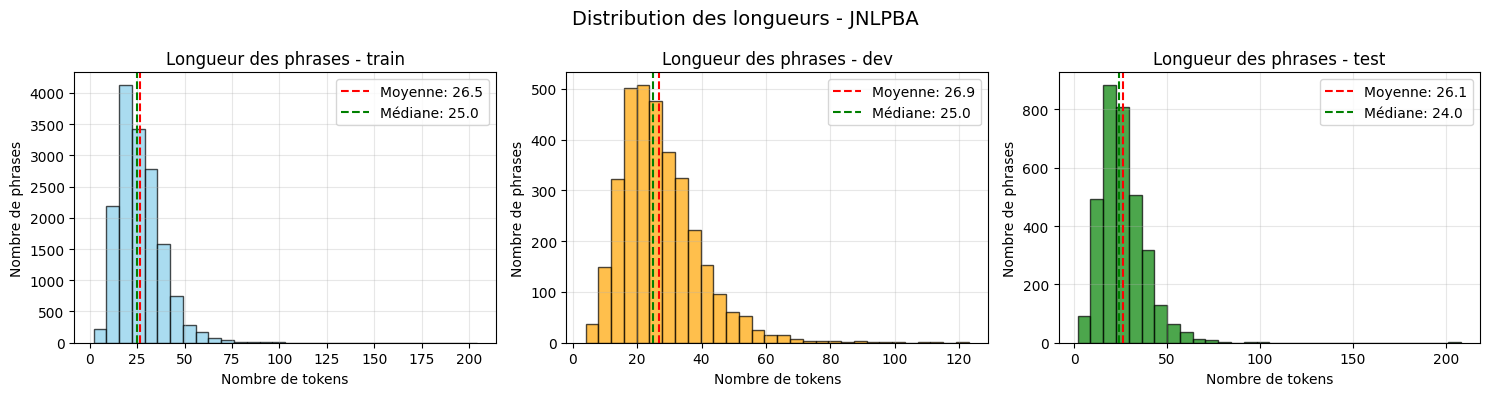


3. DISTRIBUTION DES CLASSES D'ENTITÉS
----------------------------------------

Fréquences absolues:
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                       322,900     70,740     70,970
B-DNA                     7,713      2,019        857
B-RNA                       732        241         96
B-cell_line               3,196        741        393
B-cell_type               5,853      1,056      1,730
B-protein                26,352      4,477      4,507
I-DNA                    12,762      3,404      1,397
I-RNA                     1,106        455        156
I-cell_line               6,234      1,350        792
I-cell_type               7,733      1,315      2,691
I-protein                20,849      4,551      4,222

Pourcentages (par split):
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                         77.7%      78.3%      80.8%
B-DNA  

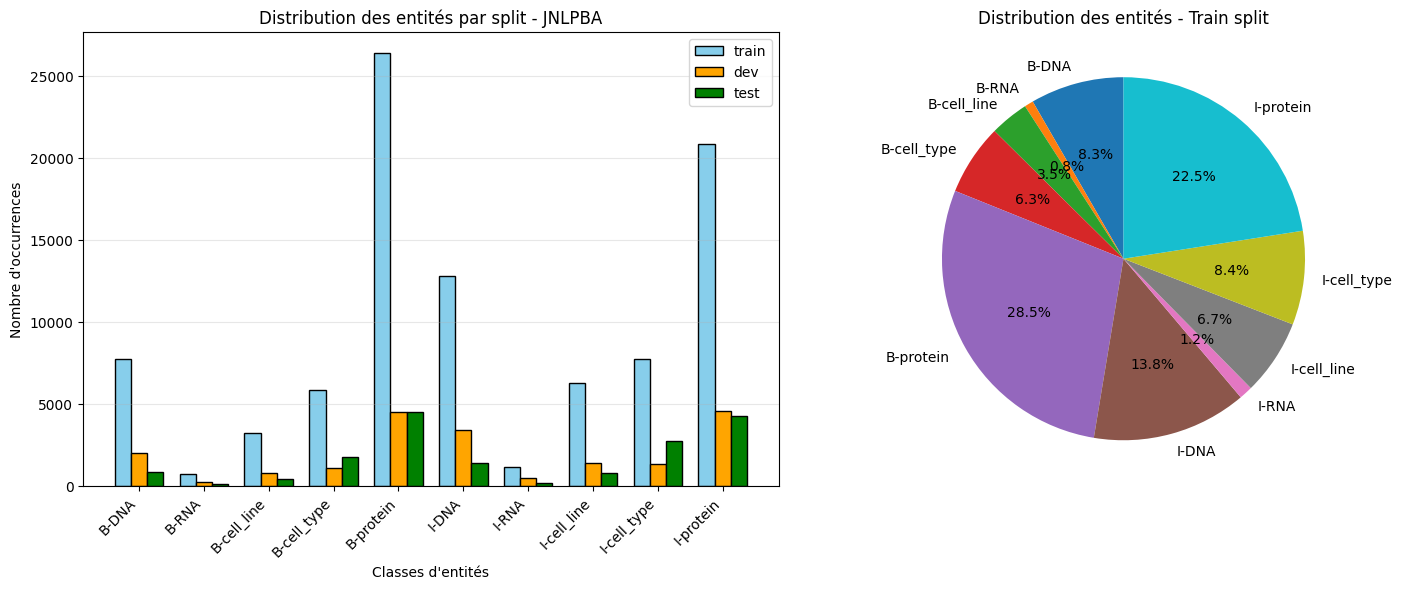


5. ENTITÉS PAR PHRASE
----------------------------------------

TRAIN:
  Entités/phrase (moyenne): 5.90
  Entités/phrase (médiane): 5.0
  Phrases sans entité: 1,553 (9.9%)

DEV:
  Entités/phrase (moyenne): 5.84
  Entités/phrase (médiane): 5.0
  Phrases sans entité: 412 (12.3%)

TEST:
  Entités/phrase (moyenne): 5.01
  Entités/phrase (médiane): 4.0
  Phrases sans entité: 571 (17.0%)


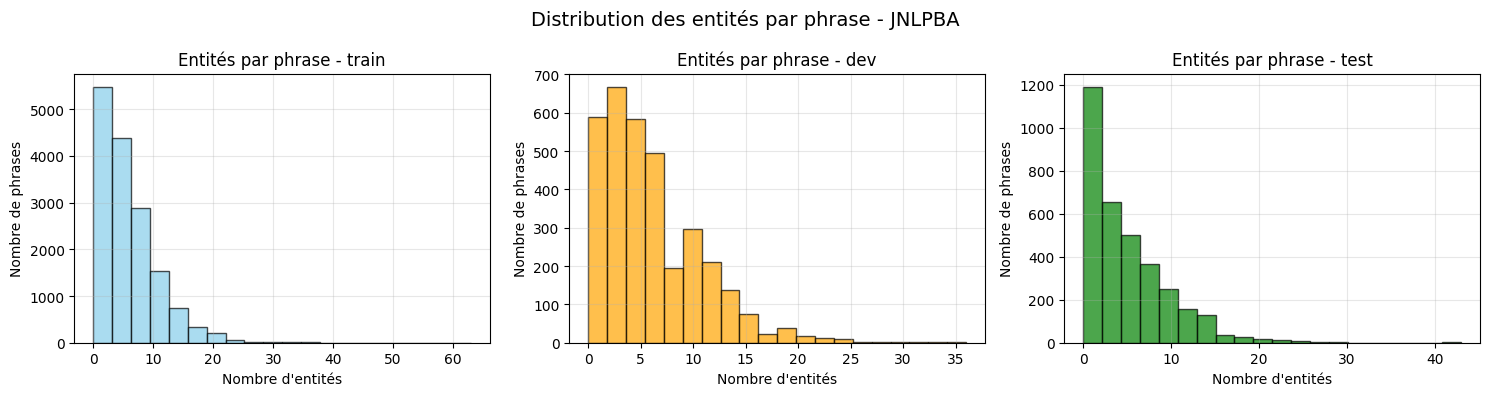


6. ANALYSE DES TAGS BIO
----------------------------------------
Total des tags: 593,590
  B: 59,963 (10.1%)
  I: 69,017 (11.6%)
  O: 464,610 (78.3%)
  autres: 0 (0.0%)

7. INFORMATIONS SUPPLÉMENTAIRES
----------------------------------------
Taille du vocabulaire: 12,664 mots
Taille du vocabulaire caractères: 85
Nombre de classes uniques: 12
Classes: ['<PAD>', 'B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']

ANALYSE TERMINÉE


In [5]:
visualize_dataset_distribution(results_jnlpba, dataset_name="JNLPBA")

Model architecture

In [10]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)
        optimizer.zero_grad()
        # Passer les tags -> forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, idx_to_tag):
    """
    Evaluate model (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss (tags fournis)
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list
            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor -> numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculate precision, recall, F1-score
    """
    
    
    # Filter out 'O' tags for entity-specific metrics
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


JNLPBA Dataset

In [6]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    embedding_url: str = None,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 40,
    patience: int = 4,   
    checkpoints_dir="./checkpoints",
):
    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']

    comb_name = "WE"
    if use_char_cnn and use_char_lstm:
        comb_name += "_char_bilstm_cnn"
    elif use_char_cnn:
        comb_name += "_char_cnn"
    elif use_char_lstm:
        comb_name += "_char_bilstm"

    if use_attention:
        comb_name += "_attention"
    if use_fc_fusion:
        comb_name += "_fc"

    checkpoints_path = f"{checkpoints_dir}/{comb_name}/best_model.pt"
    os.makedirs(os.path.dirname(checkpoints_path), exist_ok=True)

    # Chargement des embeddings
    if embedding_url:
        pretrained_embeddings = load_word2vec_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        pretrained_embeddings = loaders['pretrained_embeddings']
    else:
        print("Embedding nul")
        return

    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        dataset=dataset_name,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Adam optimizer avec L2 / weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Scheduler manuel: decay rate selon dataset
    decay_rate = 0.90 if dataset_name == 'JNLPBA' else 0.95

    best_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [], 'dev_loss': [], 'dev_f1': [],
        'dev_precision': [], 'dev_recall': [], 'lr': []
    }

    for epoch in range(epochs):
        # 1. Train
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # 2. Eval
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)

        # 3. Appliquer decay rate
        for g in optimizer.param_groups:
            g['lr'] *= decay_rate

        # 4. Historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['dev_precision'].append(precision)
        history['dev_recall'].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # 5. Early stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé: F1 {f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered après {epoch+1} epochs.")
            break


    checkpoint = torch.load(checkpoints_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_preds, test_targets = evaluate(model, test_loader, device, idx_to_tag)
    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)

    return model, history


## Combinaison 1:  WE

In [8]:
model_jnlpba_we, history_jnlpba_we = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 2,776,980


Training: 100%|██████████| 491/491 [01:43<00:00,  4.76it/s]


Epoch 01/40 | Train loss: 340.5290 | Dev loss: 179.5428 | P: 0.7050 R: 0.6376 F1: 0.6621 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6621


Training: 100%|██████████| 491/491 [01:41<00:00,  4.83it/s]


Epoch 02/40 | Train loss: 133.8148 | Dev loss: 153.7708 | P: 0.7429 R: 0.6498 F1: 0.6886 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.6886


Training: 100%|██████████| 491/491 [01:40<00:00,  4.91it/s]


Epoch 03/40 | Train loss: 100.6912 | Dev loss: 139.6690 | P: 0.7269 R: 0.6971 F1: 0.7097 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7097


Training: 100%|██████████| 491/491 [01:40<00:00,  4.86it/s]


Epoch 04/40 | Train loss: 83.4041 | Dev loss: 136.0465 | P: 0.7432 R: 0.6894 F1: 0.7147 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7147


Training: 100%|██████████| 491/491 [01:51<00:00,  4.39it/s]


Epoch 05/40 | Train loss: 70.4567 | Dev loss: 135.6585 | P: 0.7365 R: 0.6988 F1: 0.7159 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7159


Training: 100%|██████████| 491/491 [01:56<00:00,  4.21it/s]


Epoch 06/40 | Train loss: 61.4706 | Dev loss: 134.6439 | P: 0.7368 R: 0.7133 F1: 0.7235 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7235


Training: 100%|██████████| 491/491 [01:47<00:00,  4.58it/s]


Epoch 07/40 | Train loss: 53.5639 | Dev loss: 138.4773 | P: 0.7317 R: 0.7039 F1: 0.7165 | LR: 0.000478


Training: 100%|██████████| 491/491 [01:39<00:00,  4.96it/s]


Epoch 08/40 | Train loss: 47.6108 | Dev loss: 141.6762 | P: 0.7282 R: 0.6897 F1: 0.7070 | LR: 0.000430


Training: 100%|██████████| 491/491 [02:00<00:00,  4.06it/s]


Epoch 09/40 | Train loss: 41.4167 | Dev loss: 147.9945 | P: 0.7263 R: 0.6949 F1: 0.7091 | LR: 0.000387


Training: 100%|██████████| 491/491 [01:44<00:00,  4.71it/s]


Epoch 10/40 | Train loss: 36.9396 | Dev loss: 157.4033 | P: 0.7174 R: 0.6965 F1: 0.7052 | LR: 0.000349
Early stopping triggered après 10 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 151.0833
Precision: 0.6554
Recall: 0.6690
F1-score: 0.6591


In [7]:
def print_model_layers(model: torch.nn.Module):
    print(f"{'Layer (type)':30} | {'Param #':>12}")
    print("-"*45)
    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0: 
            param_count = sum(p.numel() for p in module.parameters())
            print(f"{name + ' (' + module.__class__.__name__ + ')':30} | {param_count:12,}")
            total_params += param_count
    print("-"*45)
    print(f"{'Total parameters':30} | {total_params:12,}")


In [10]:
print_model_layers(model_jnlpba_we)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
context_lstm (LSTM)            |      241,600
emission (Linear)              |        2,412
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    2,776,980


In [9]:
import pickle
import os

def save_vocabularies(data_dict, save_dir):
    """Sauvegarde les vocabulaires et mappings"""
    os.makedirs(save_dir, exist_ok=True)
    
    with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['vocab'], f)
    
    with open(os.path.join(save_dir, 'char_vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['char_vocab'], f)
    
    with open(os.path.join(save_dir, 'tag_to_idx.pkl'), 'wb') as f:
        pickle.dump(data_dict['tag_to_idx'], f)
    
    with open(os.path.join(save_dir, 'idx_to_tag.pkl'), 'wb') as f:
        pickle.dump(data_dict['idx_to_tag'], f)
    
    print(f"Vocabulaires sauvegardés dans {save_dir}")
    
save_vocabularies(results_jnlpba, './vocab/jnlpba')

Vocabulaires sauvegardés dans ./vocab/jnlpba


In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1 (double axis)
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2,color="red")
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2,color="green")

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


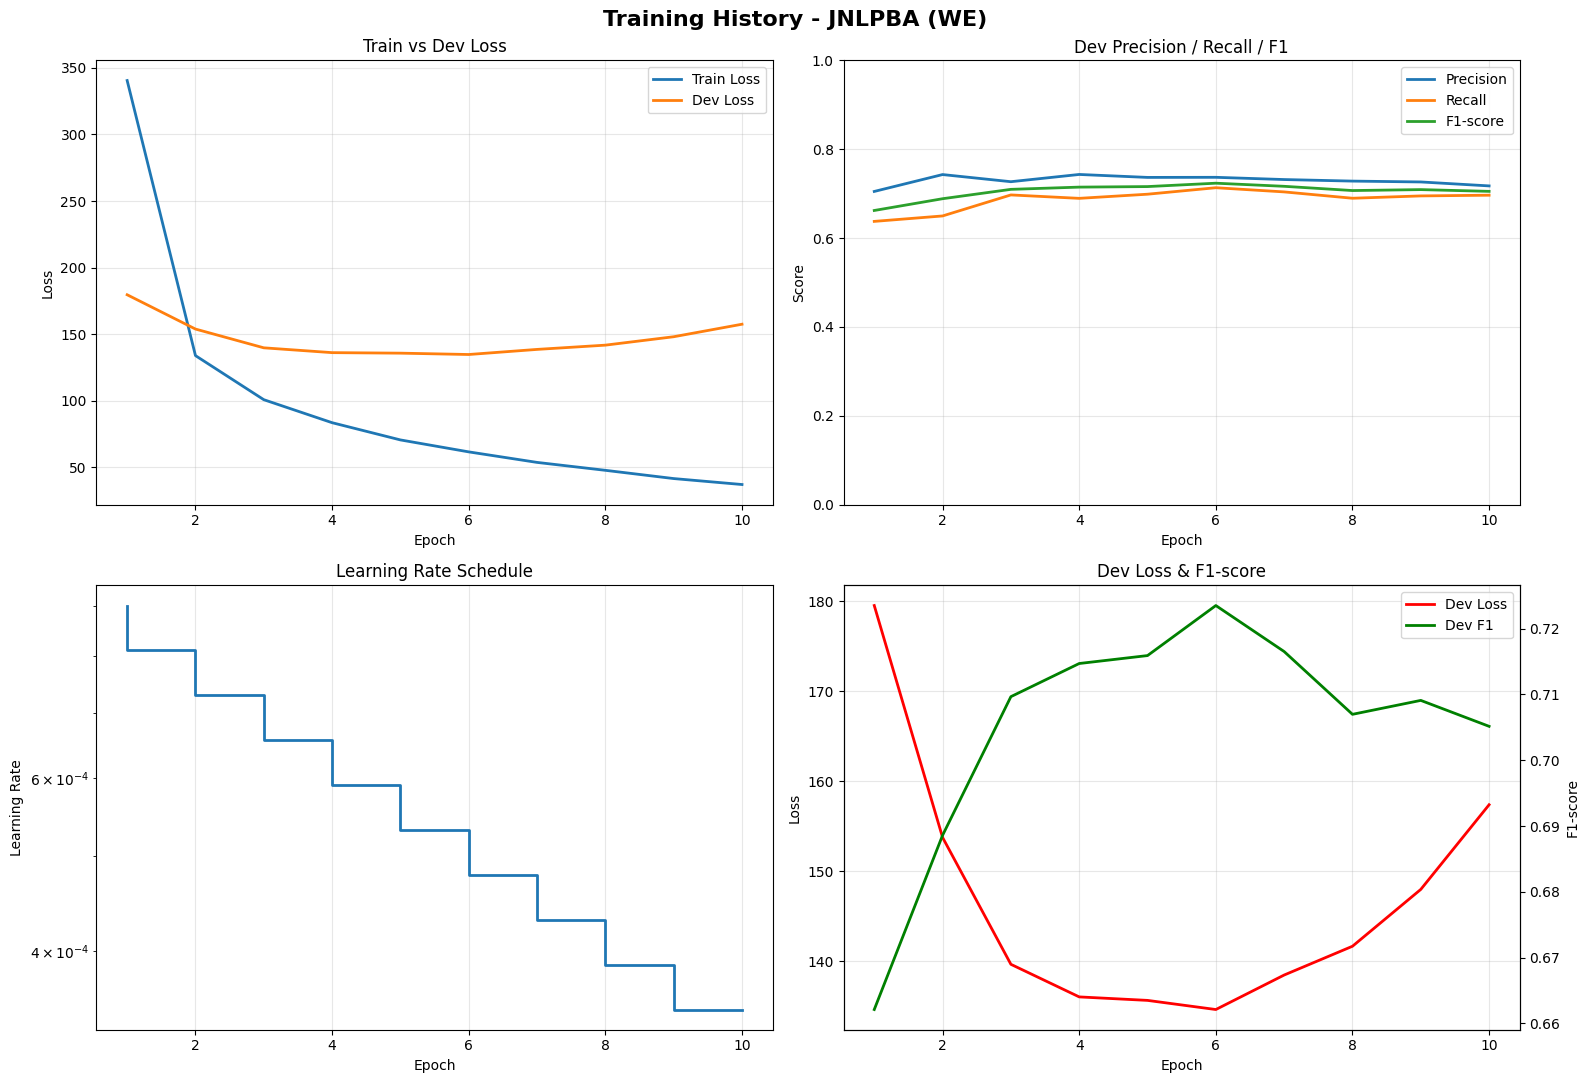


STATISTIQUES FINALES - JNLPBA (WE)
Meilleur F1 (dev)       : 0.7235
Meilleure Precision(dev): 0.7432
Meilleur Recall (dev)   : 0.7133
Final train loss        : 36.9396
Final dev loss          : 157.4033
Final learning rate     : 0.000349


In [13]:
plot_training_history(history_jnlpba_we, dataset_name="JNLPBA (WE)")

In [9]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
        dataset=dataset_name,
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=use_char_cnn,       
    use_char_lstm=use_char_lstm,      
    use_attention=use_attention,     
    use_fc_fusion=use_fc_fusion,  
    pretrained_embeddings=None,  
    word_embed_dim=200,
    lstm_hidden_dim=lstm_hidden,
    dropout=0.5
).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag

def plot_confusion_matrix_by_class(predictions, targets, idx_to_tag, dataset_name, 
                                   normalize=True, figsize=(12, 10),title="Matrice de confusion"):
    """
    Affiche la matrice de confusion par classe avec des statistiques détaillées
    """
    # Vérification des types
    print(f"\nVérification des types:")
    print(f"  Type predictions[0]: {type(predictions[0])}, valeur: {predictions[0]}")
    print(f"  Type targets[0]: {type(targets[0])}, valeur: {targets[0]}")
    
    # S'assurer que tout est string
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]
    
    print(f"\nStatistiques:")
    print(f"  Total tokens: {len(predictions)}")
    print(f"  Entity tokens: {len(targets)}")
    print(f"  Unique entity tags in targets: {set(targets)}")
    print(f"  Unique entity tags in predictions: {set(predictions)}")
    
    # Obtenir les classes uniques (sauf 'O')
    all_unique_tags = sorted(set(targets + predictions))
    
    # Filtrer pour garder seulement les tags valides (pas les nombres)
    valid_tags = [tag for tag in all_unique_tags if not tag.isdigit()]
    
    # Si on a des tags numériques, c'est qu'il y a un problème de conversion
    numeric_tags = [tag for tag in all_unique_tags if tag.isdigit()]
    if numeric_tags:
        print(f"\nATTENTION: Tags numériques trouvés: {numeric_tags}")
        print("Cela indique que les prédictions sont des indices, pas des tags!")
        print(f"Mapping idx_to_tag: {dict(list(idx_to_tag.items())[:10])}")
    
    print(f"  Tags valides à plotter: {valid_tags}")
    
    if not valid_tags:
        print("Aucune entité valide trouvée dans les données!")
        return

    cm = confusion_matrix(targets, predictions, labels=valid_tags)
    supports = cm.sum(axis=1)  
    
    if normalize:
        # Éviter la division par zéro
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = cm.astype('float') / supports[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)
        cm_to_plot = cm_normalized
        fmt = '.2f'
    else:
        cm_to_plot = cm
        fmt = 'd'
    
    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Si la matrice est trop grande, ajuster la taille
    if len(valid_tags) > 15:
        figsize = (max(12, len(valid_tags)), max(10, len(valid_tags)))
        plt.figure(figsize=figsize)
    
    sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=valid_tags, yticklabels=valid_tags,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    
    plt.title(title,fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    filtered_targets = []
    filtered_preds = []
    
    for t, p in zip(targets, predictions):
        if t in valid_tags and p in valid_tags:
            filtered_targets.append(t)
            filtered_preds.append(p)
    
    if filtered_targets:
        report = classification_report(filtered_targets, filtered_preds, 
                                       labels=valid_tags, zero_division=0)
        print(report)
    else:
        print("Pas assez de données pour générer le rapport")

def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


In [19]:
model_path = "./checkpoints/JNLPBA/we/best_model.pt"
model, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions, targets = predict_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/we/best_model.pt
Best F1 enregistré: 0.7235
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                  correct
 


Accuracy globale: 0.9251

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Unique entity tags in predictions: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


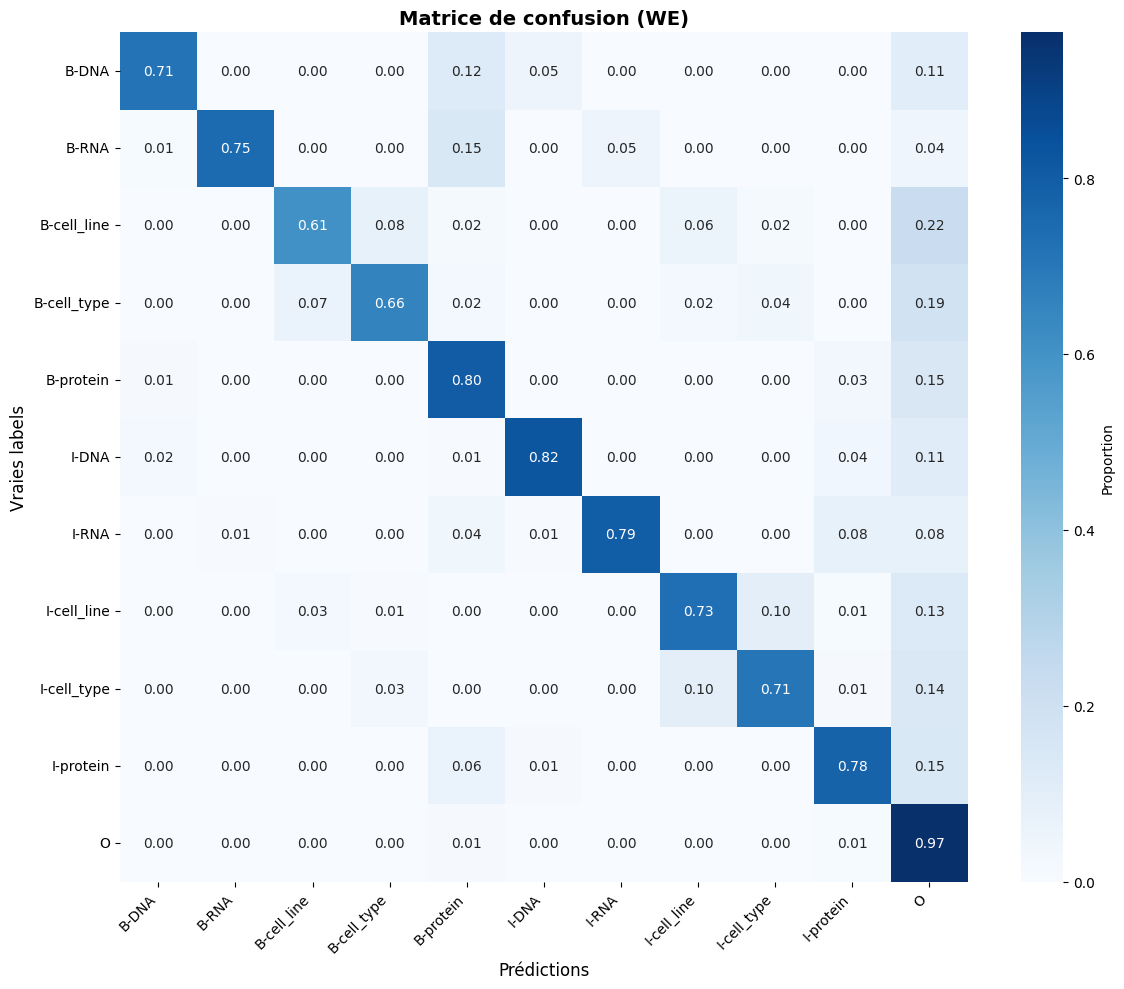

              precision    recall  f1-score   support

       B-DNA       0.70      0.71      0.71       857
       B-RNA       0.68      0.75      0.71        96
 B-cell_line       0.51      0.61      0.55       393
 B-cell_type       0.80      0.66      0.72      1730
   B-protein       0.73      0.80      0.76      4507
       I-DNA       0.79      0.82      0.80      1397
       I-RNA       0.78      0.79      0.78       156
 I-cell_line       0.57      0.73      0.64       792
 I-cell_type       0.87      0.71      0.78      2691
   I-protein       0.78      0.78      0.78      4222
           O       0.97      0.97      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.74      0.76      0.75     87803
weighted avg       0.93      0.93      0.93     87803



In [20]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets, predictions)
print(f"\nAccuracy globale: {accuracy:.4f}")


if set(predictions) == set(targets) or all(isinstance(p, str) for p in predictions):
    plot_confusion_matrix_by_class(
        predictions=predictions,
        targets=targets,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets[:10])}")

## Combinaison 2:  WE + attention

In [21]:
model_we_attention, history_we_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,005,556


Training:   0%|          | 0/491 [00:00<?, ?it/s]

Training: 100%|██████████| 491/491 [07:09<00:00,  1.14it/s]


Epoch 01/40 | Train loss: 298.5126 | Dev loss: 179.3384 | P: 0.6919 R: 0.6981 F1: 0.6918 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6918


Training: 100%|██████████| 491/491 [07:09<00:00,  1.14it/s]


Epoch 02/40 | Train loss: 129.9658 | Dev loss: 151.1100 | P: 0.7310 R: 0.6847 F1: 0.7046 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7046


Training: 100%|██████████| 491/491 [07:06<00:00,  1.15it/s]


Epoch 03/40 | Train loss: 98.7976 | Dev loss: 145.2398 | P: 0.7428 R: 0.6847 F1: 0.7079 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7079


Training: 100%|██████████| 491/491 [07:08<00:00,  1.15it/s]


Epoch 04/40 | Train loss: 80.4330 | Dev loss: 135.0237 | P: 0.7280 R: 0.7242 F1: 0.7256 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7256


Training: 100%|██████████| 491/491 [09:09<00:00,  1.12s/it]


Epoch 05/40 | Train loss: 66.6731 | Dev loss: 141.4666 | P: 0.7433 R: 0.6842 F1: 0.7117 | LR: 0.000590


Training: 100%|██████████| 491/491 [08:15<00:00,  1.01s/it]


Epoch 06/40 | Train loss: 57.0539 | Dev loss: 142.8521 | P: 0.7370 R: 0.6761 F1: 0.7023 | LR: 0.000531


Training: 100%|██████████| 491/491 [07:41<00:00,  1.06it/s]


Epoch 07/40 | Train loss: 48.7265 | Dev loss: 150.7861 | P: 0.7360 R: 0.6867 F1: 0.7078 | LR: 0.000478


Training: 100%|██████████| 491/491 [07:47<00:00,  1.05it/s]


Epoch 08/40 | Train loss: 41.0895 | Dev loss: 159.5323 | P: 0.7276 R: 0.6925 F1: 0.7072 | LR: 0.000430
Early stopping triggered après 8 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 156.8233
Precision: 0.6313
Recall: 0.6744
F1-score: 0.6451


In [22]:
print_model_layers(model_we_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
context_lstm (LSTM)            |      337,920
attention_layer.W (Linear)     |          256
attention_projection (Linear)  |      131,328
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,005,556


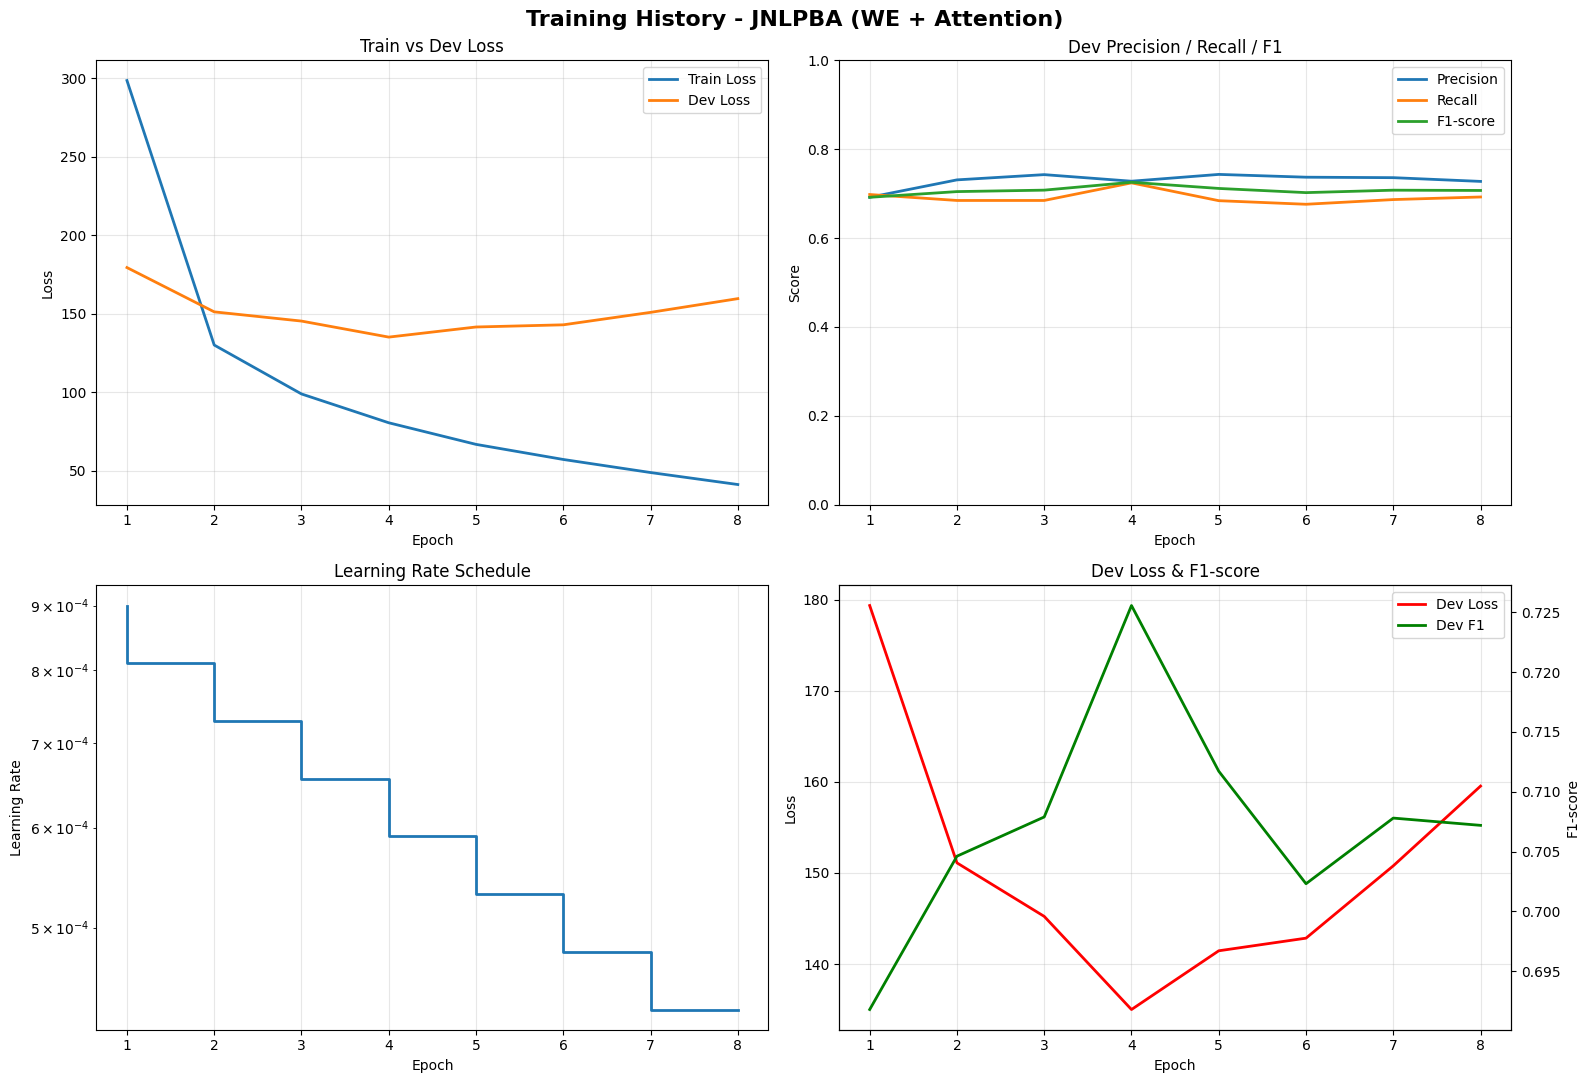


STATISTIQUES FINALES - JNLPBA (WE + Attention)
Meilleur F1 (dev)       : 0.7256
Meilleure Precision(dev): 0.7433
Meilleur Recall (dev)   : 0.7242
Final train loss        : 41.0895
Final dev loss          : 159.5323
Final learning rate     : 0.000430


In [23]:
plot_training_history(history_we_attention, dataset_name="JNLPBA (WE + Attention)")

In [24]:
model_path = "./checkpoints/JNLPBA/WE_attention/best_model.pt"
model_we_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions_we_attention, targets_we_attention = predict_on_test_set(
    model=model_we_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_attention/best_model.pt
Best F1 enregistré: 0.7256
Époque: 3
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                 


Accuracy globale: 0.9250

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Unique entity tags in predictions: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


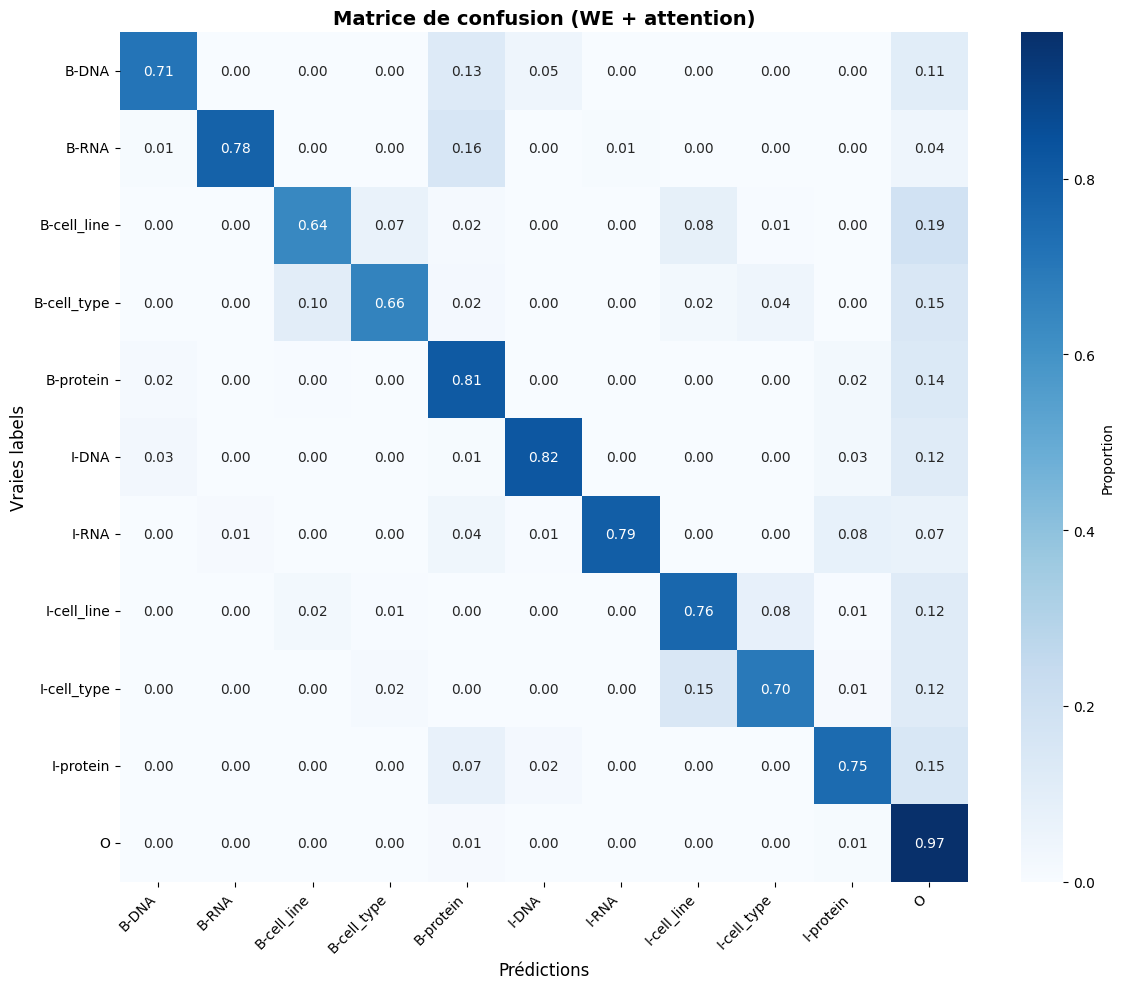

              precision    recall  f1-score   support

       B-DNA       0.68      0.71      0.69       857
       B-RNA       0.57      0.78      0.66        96
 B-cell_line       0.44      0.64      0.52       393
 B-cell_type       0.82      0.66      0.73      1730
   B-protein       0.73      0.81      0.77      4507
       I-DNA       0.78      0.82      0.80      1397
       I-RNA       0.76      0.79      0.78       156
 I-cell_line       0.50      0.76      0.60       792
 I-cell_type       0.87      0.70      0.77      2691
   I-protein       0.80      0.75      0.77      4222
           O       0.97      0.97      0.97     70962

    accuracy                           0.92     87803
   macro avg       0.72      0.76      0.73     87803
weighted avg       0.93      0.92      0.93     87803



In [25]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_attention, predictions_we_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_attention) == set(targets_we_attention) or all(isinstance(p, str) for p in predictions_we_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_attention,
        targets=targets_we_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_attention[:10])}")

## Combinaison 3:  WE + char(bi-lstm)

In [26]:
model_we_char_bilstm , history_we_char_bilstm = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,021,422


Training: 100%|██████████| 491/491 [02:18<00:00,  3.54it/s]


Epoch 01/40 | Train loss: 313.6751 | Dev loss: 194.3859 | P: 0.7218 R: 0.6242 F1: 0.6581 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6581


Training: 100%|██████████| 491/491 [02:04<00:00,  3.93it/s]


Epoch 02/40 | Train loss: 127.5072 | Dev loss: 146.9020 | P: 0.7398 R: 0.6942 F1: 0.7132 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7132


Training: 100%|██████████| 491/491 [02:28<00:00,  3.32it/s]


Epoch 03/40 | Train loss: 97.6033 | Dev loss: 138.8848 | P: 0.7507 R: 0.6822 F1: 0.7099 | LR: 0.000729


Training: 100%|██████████| 491/491 [02:28<00:00,  3.30it/s]


Epoch 04/40 | Train loss: 80.2421 | Dev loss: 135.2623 | P: 0.7513 R: 0.6771 F1: 0.7075 | LR: 0.000656


Training: 100%|██████████| 491/491 [02:32<00:00,  3.22it/s]


Epoch 05/40 | Train loss: 68.0527 | Dev loss: 133.5184 | P: 0.7515 R: 0.6951 F1: 0.7186 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7186


Training: 100%|██████████| 491/491 [02:46<00:00,  2.94it/s]


Epoch 06/40 | Train loss: 59.1323 | Dev loss: 138.7129 | P: 0.7394 R: 0.6906 F1: 0.7094 | LR: 0.000531


Training: 100%|██████████| 491/491 [02:46<00:00,  2.94it/s]


Epoch 07/40 | Train loss: 51.7155 | Dev loss: 138.3099 | P: 0.7485 R: 0.6780 F1: 0.7087 | LR: 0.000478


Training: 100%|██████████| 491/491 [02:41<00:00,  3.04it/s]


Epoch 08/40 | Train loss: 45.6687 | Dev loss: 143.3758 | P: 0.7457 R: 0.6784 F1: 0.7081 | LR: 0.000430


Training: 100%|██████████| 491/491 [02:53<00:00,  2.83it/s]


Epoch 09/40 | Train loss: 40.3103 | Dev loss: 141.3149 | P: 0.7347 R: 0.6848 F1: 0.7050 | LR: 0.000387
Early stopping triggered après 9 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 135.1679
Precision: 0.6771
Recall: 0.6671
F1-score: 0.6705


In [27]:
print_model_layers(model_we_char_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      440,320
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,021,422


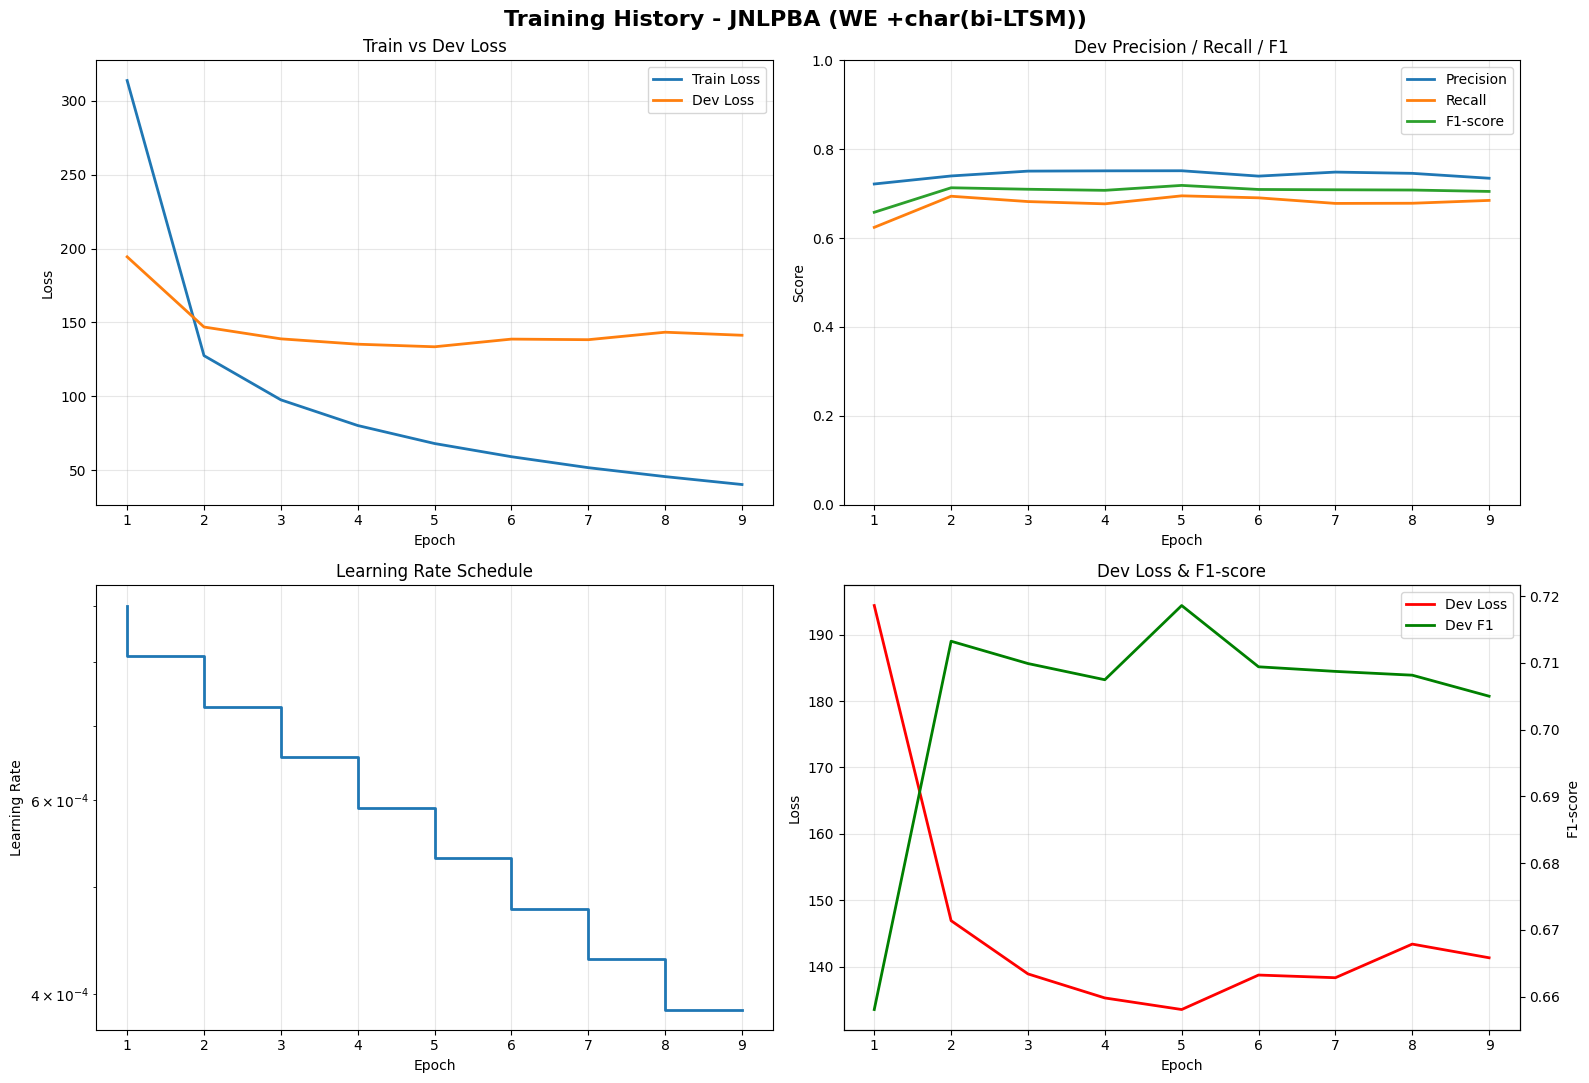


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM))
Meilleur F1 (dev)       : 0.7186
Meilleure Precision(dev): 0.7515
Meilleur Recall (dev)   : 0.6951
Final train loss        : 40.3103
Final dev loss          : 141.3149
Final learning rate     : 0.000387


In [28]:
plot_training_history(history_we_char_bilstm, dataset_name="JNLPBA (WE +char(bi-LTSM))")

In [29]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt"
model_we_char_bilstm , device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)

test_loader = results_jnlpba['test_loader']
predictions_we_char, targets_we_char = predict_on_test_set(
    model=model_we_char_bilstm ,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm/best_model.pt
Best F1 enregistré: 0.7186
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O               


Accuracy globale: 0.9290

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Unique entity tags in predictions: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


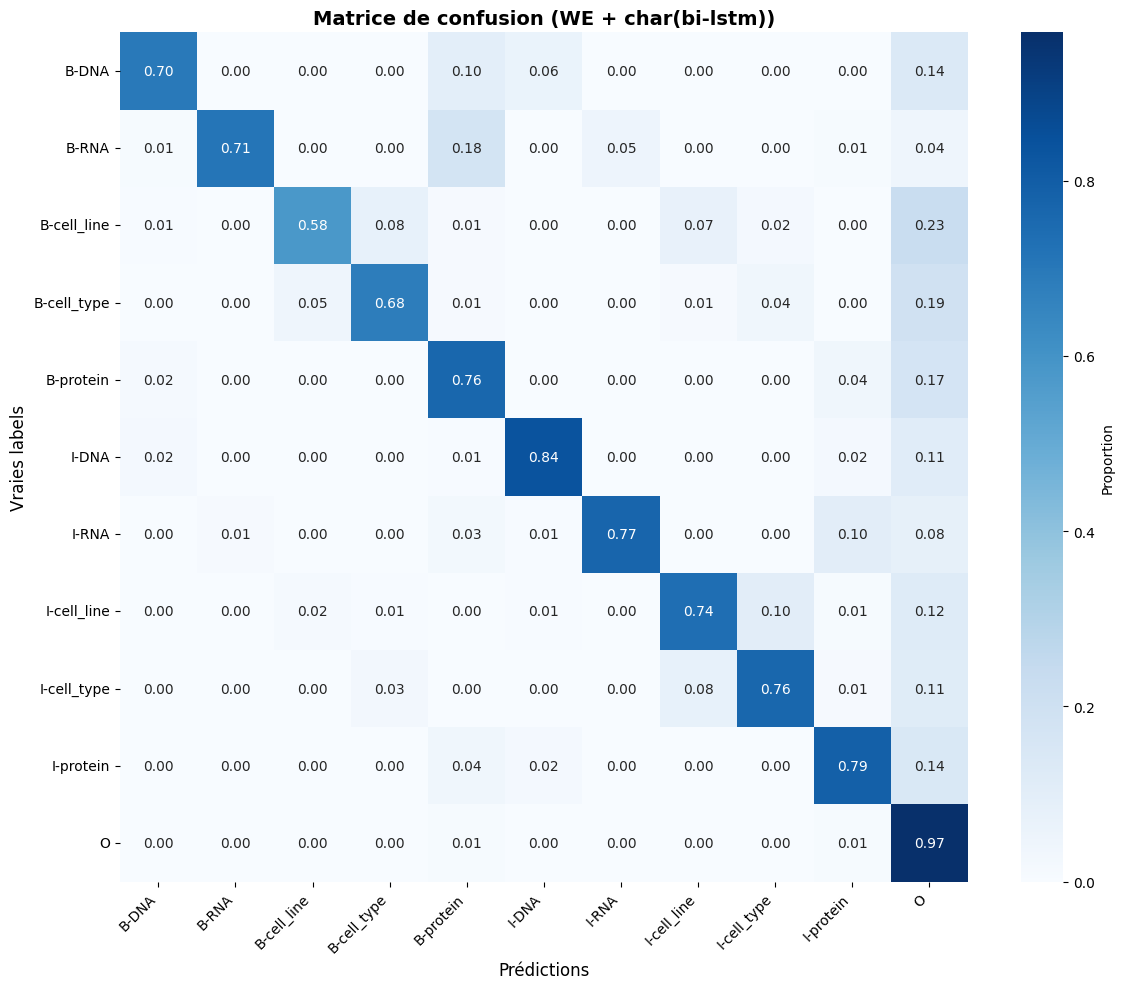

              precision    recall  f1-score   support

       B-DNA       0.69      0.70      0.69       857
       B-RNA       0.76      0.71      0.73        96
 B-cell_line       0.59      0.58      0.59       393
 B-cell_type       0.82      0.68      0.74      1730
   B-protein       0.77      0.76      0.77      4507
       I-DNA       0.75      0.84      0.79      1397
       I-RNA       0.79      0.77      0.78       156
 I-cell_line       0.63      0.74      0.68       792
 I-cell_type       0.86      0.76      0.81      2691
   I-protein       0.79      0.79      0.79      4222
           O       0.96      0.97      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.76      0.76      0.76     87803
weighted avg       0.93      0.93      0.93     87803



In [30]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char, predictions_we_char)
print(f"\nAccuracy globale: {accuracy:.4f}")
if set(predictions_we_char) == set(targets_we_char) or all(isinstance(p, str) for p in predictions_we_char):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char,
        targets=targets_we_char,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char[:10])}")

## Combinaison 4:  WE + char(bi-lstm) + attention

In [31]:
model_we_char_attention, history_we_char_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,153,006


Training: 100%|██████████| 491/491 [14:12<00:00,  1.74s/it]


Epoch 01/40 | Train loss: 288.1551 | Dev loss: 175.8876 | P: 0.7214 R: 0.6482 F1: 0.6736 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6736


Training: 100%|██████████| 491/491 [14:34<00:00,  1.78s/it]


Epoch 02/40 | Train loss: 124.3926 | Dev loss: 142.5763 | P: 0.7427 R: 0.6757 F1: 0.7045 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7045


Training: 100%|██████████| 491/491 [14:21<00:00,  1.75s/it]


Epoch 03/40 | Train loss: 94.0852 | Dev loss: 138.8625 | P: 0.7489 R: 0.6763 F1: 0.7067 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7067


Training: 100%|██████████| 491/491 [14:22<00:00,  1.76s/it]


Epoch 04/40 | Train loss: 75.8781 | Dev loss: 133.1398 | P: 0.7553 R: 0.6784 F1: 0.7089 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7089


Training: 100%|██████████| 491/491 [15:45<00:00,  1.93s/it]


Epoch 05/40 | Train loss: 63.2792 | Dev loss: 131.3230 | P: 0.7479 R: 0.6943 F1: 0.7190 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7190


Training: 100%|██████████| 491/491 [16:26<00:00,  2.01s/it]


Epoch 06/40 | Train loss: 53.4217 | Dev loss: 135.3330 | P: 0.7540 R: 0.6838 F1: 0.7144 | LR: 0.000531


Training: 100%|██████████| 491/491 [16:17<00:00,  1.99s/it]


Epoch 07/40 | Train loss: 45.0752 | Dev loss: 139.0862 | P: 0.7346 R: 0.7078 F1: 0.7186 | LR: 0.000478


Training: 100%|██████████| 491/491 [16:17<00:00,  1.99s/it]


Epoch 08/40 | Train loss: 37.6945 | Dev loss: 148.4389 | P: 0.7392 R: 0.6848 F1: 0.7071 | LR: 0.000430


Training: 100%|██████████| 491/491 [16:07<00:00,  1.97s/it]


Epoch 09/40 | Train loss: 31.5460 | Dev loss: 156.2470 | P: 0.7402 R: 0.6910 F1: 0.7137 | LR: 0.000387
Early stopping triggered après 9 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 148.8915
Precision: 0.6593
Recall: 0.6587
F1-score: 0.6530


In [32]:
print_model_layers(model_we_char_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      440,320
attention_layer.W (Linear)     |          256
attention_projection (Linear)  |      131,328
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,153,006


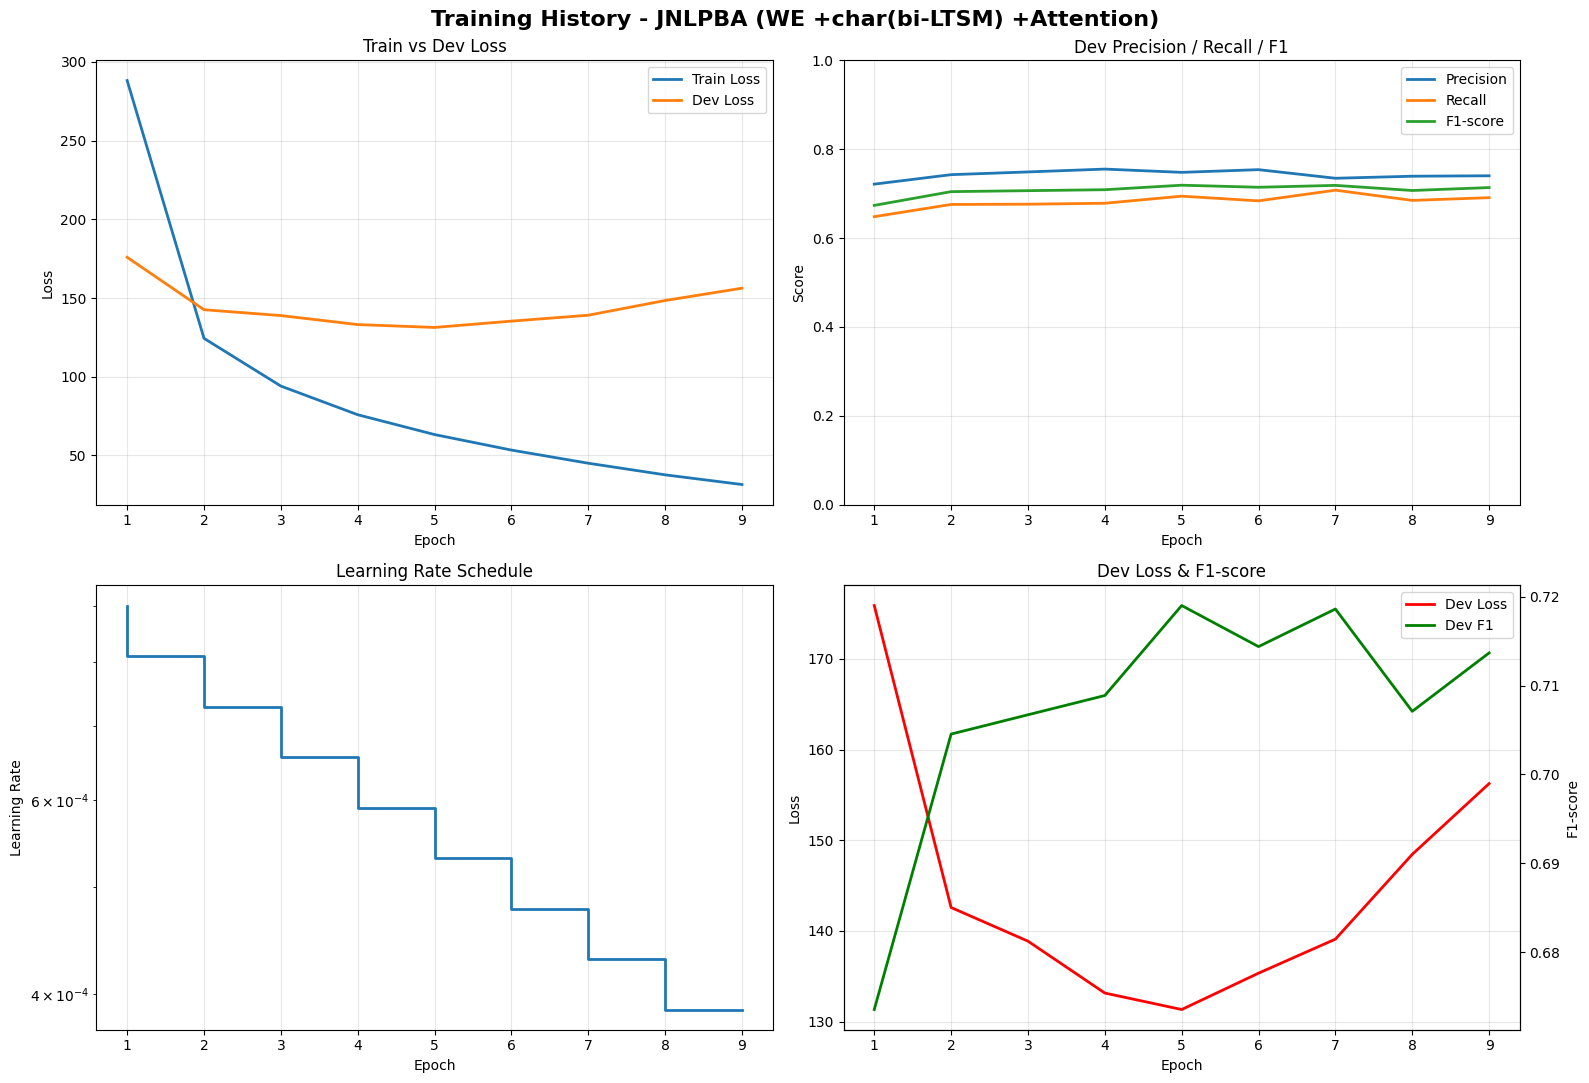


STATISTIQUES FINALES - JNLPBA (WE +char(bi-LTSM) +Attention)
Meilleur F1 (dev)       : 0.7190
Meilleure Precision(dev): 0.7553
Meilleur Recall (dev)   : 0.7078
Final train loss        : 31.5460
Final dev loss          : 156.2470
Final learning rate     : 0.000387


In [37]:
plot_training_history(history_we_char_attention, dataset_name="JNLPBA (WE +char(bi-LTSM) +Attention)")

In [36]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt"
model_we_char_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions_we_char_attention, targets_we_char_attention = predict_on_test_set(
    model=model_we_char_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt
Best F1 enregistré: 0.7190
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-protein          incorrect
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O       


Accuracy globale: 0.9258

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Unique entity tags in predictions: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


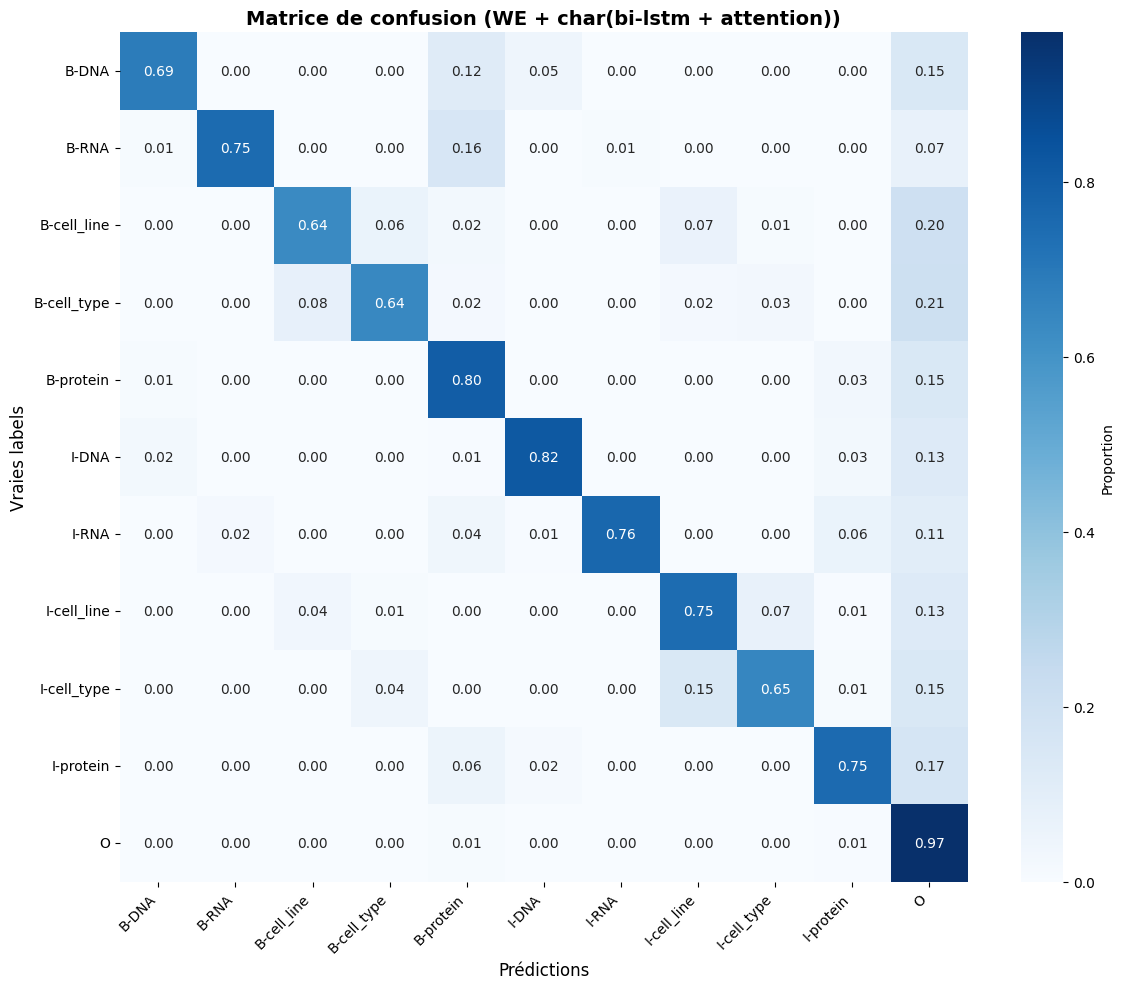

              precision    recall  f1-score   support

       B-DNA       0.73      0.69      0.71       857
       B-RNA       0.67      0.75      0.71        96
 B-cell_line       0.49      0.64      0.55       393
 B-cell_type       0.80      0.64      0.71      1730
   B-protein       0.75      0.80      0.77      4507
       I-DNA       0.78      0.82      0.80      1397
       I-RNA       0.82      0.76      0.79       156
 I-cell_line       0.51      0.75      0.61       792
 I-cell_type       0.90      0.65      0.75      2691
   I-protein       0.81      0.75      0.78      4222
           O       0.96      0.97      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.75      0.75      0.74     87803
weighted avg       0.93      0.93      0.93     87803



In [38]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_attention, predictions_we_char_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char_attention) == set(targets_we_char_attention) or all(isinstance(p, str) for p in predictions_we_char_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_attention,
        targets=targets_we_char_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm + attention))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_attention[:10])}")

## Combinaison 5:  WE + char(cnn)

In [39]:
model_we_char_cnn, history_we_char_cnn = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,000,622


Training:   0%|          | 0/491 [00:00<?, ?it/s]

Training: 100%|██████████| 491/491 [01:57<00:00,  4.19it/s]


Epoch 01/40 | Train loss: 306.0308 | Dev loss: 168.4726 | P: 0.7237 R: 0.6569 F1: 0.6815 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6815


Training: 100%|██████████| 491/491 [01:54<00:00,  4.27it/s]


Epoch 02/40 | Train loss: 129.5391 | Dev loss: 139.3652 | P: 0.7339 R: 0.7007 F1: 0.7136 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7136


Training: 100%|██████████| 491/491 [02:00<00:00,  4.07it/s]


Epoch 03/40 | Train loss: 98.6918 | Dev loss: 129.2643 | P: 0.7415 R: 0.7095 F1: 0.7244 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7244


Training: 100%|██████████| 491/491 [01:59<00:00,  4.11it/s]


Epoch 04/40 | Train loss: 81.7938 | Dev loss: 126.3728 | P: 0.7448 R: 0.7032 F1: 0.7218 | LR: 0.000656


Training: 100%|██████████| 491/491 [02:00<00:00,  4.08it/s]


Epoch 05/40 | Train loss: 69.0566 | Dev loss: 122.9858 | P: 0.7406 R: 0.7205 F1: 0.7295 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7295


Training: 100%|██████████| 491/491 [01:58<00:00,  4.13it/s]


Epoch 06/40 | Train loss: 60.7161 | Dev loss: 124.2919 | P: 0.7334 R: 0.7161 F1: 0.7229 | LR: 0.000531


Training: 100%|██████████| 491/491 [01:57<00:00,  4.19it/s]


Epoch 07/40 | Train loss: 52.9671 | Dev loss: 125.5352 | P: 0.7265 R: 0.7220 F1: 0.7232 | LR: 0.000478


Training: 100%|██████████| 491/491 [02:00<00:00,  4.09it/s]


Epoch 08/40 | Train loss: 47.1658 | Dev loss: 128.2835 | P: 0.7271 R: 0.7118 F1: 0.7186 | LR: 0.000430


Training: 100%|██████████| 491/491 [01:57<00:00,  4.16it/s]


Epoch 09/40 | Train loss: 41.9744 | Dev loss: 135.1534 | P: 0.7295 R: 0.7019 F1: 0.7118 | LR: 0.000387
Early stopping triggered après 9 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 138.5070
Precision: 0.6462
Recall: 0.6711
F1-score: 0.6536


In [40]:
print_model_layers(model_we_char_cnn)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      436,224
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,000,622


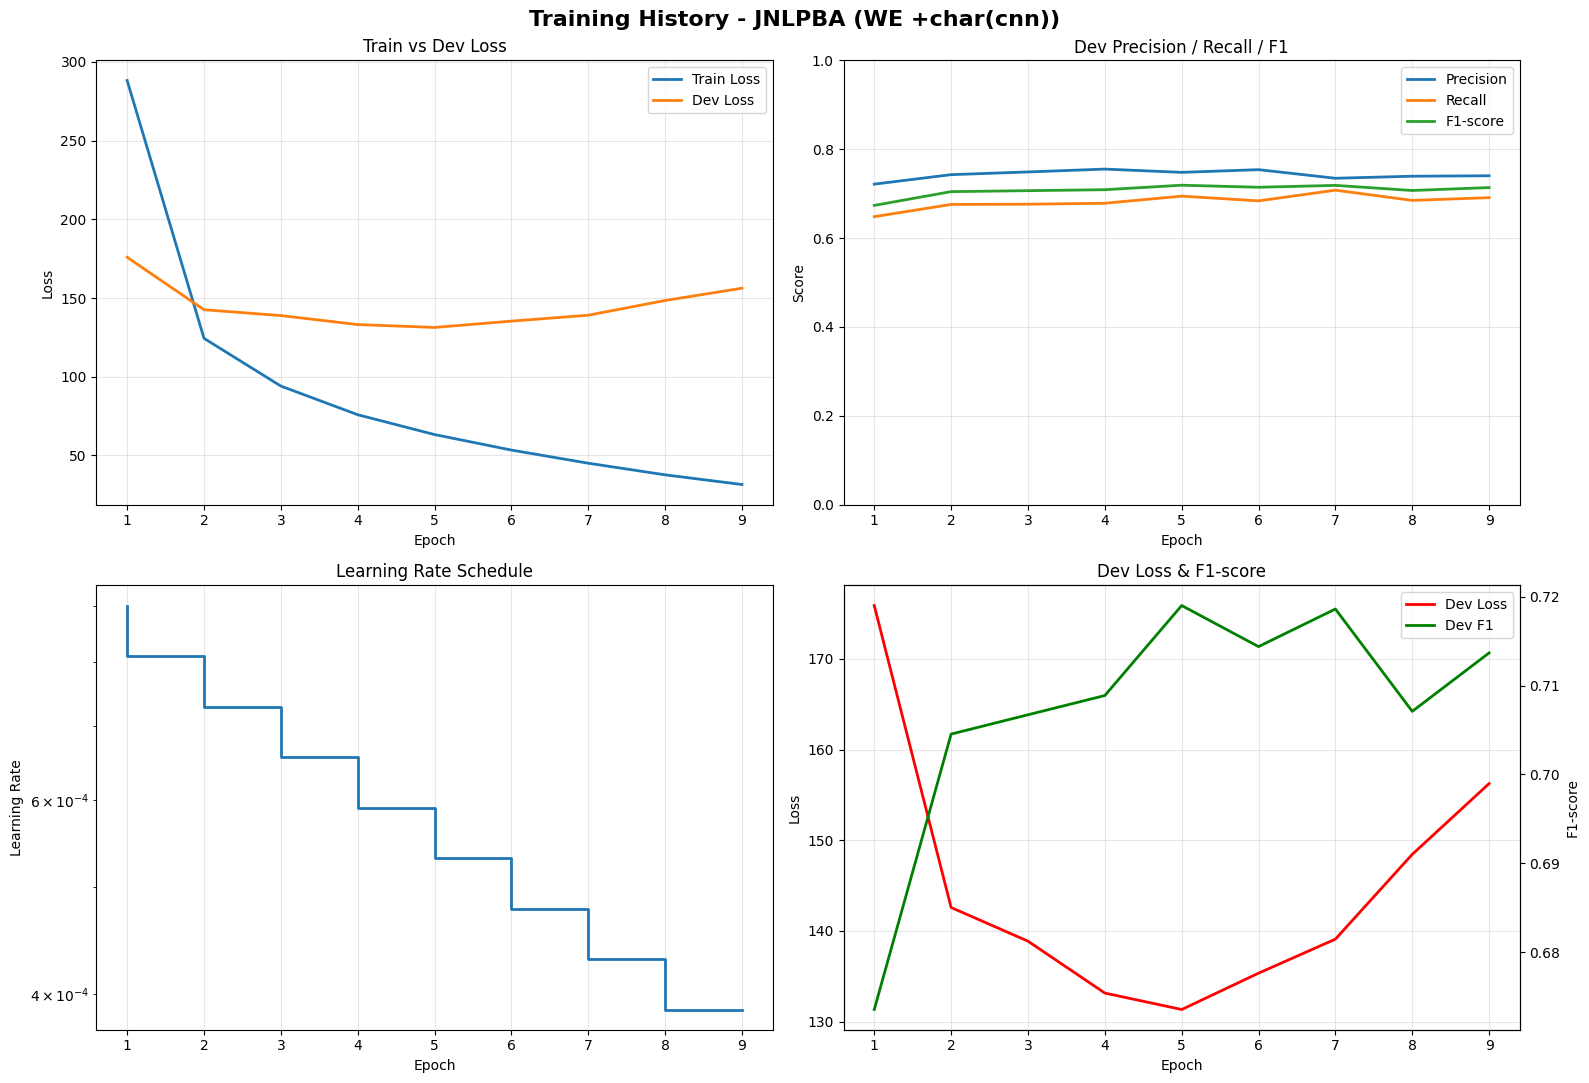


STATISTIQUES FINALES - JNLPBA (WE +char(cnn))
Meilleur F1 (dev)       : 0.7190
Meilleure Precision(dev): 0.7553
Meilleur Recall (dev)   : 0.7078
Final train loss        : 31.5460
Final dev loss          : 156.2470
Final learning rate     : 0.000387


In [41]:
plot_training_history(history_we_char_attention, dataset_name="JNLPBA (WE +char(cnn))")

In [42]:
model_path = "./checkpoints/JNLPBA/WE_char_cnn/best_model.pt"
model_we_char_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char_cnn, targets_we_char_cnn = predict_on_test_set(
    model=model_we_char_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_cnn/best_model.pt
Best F1 enregistré: 0.7295
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                  


Accuracy globale: 0.9278

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Unique entity tags in predictions: {'I-DNA', 'B-cell_type', 'B-cell_line', 'B-DNA', 'O', 'I-protein', 'I-RNA', 'B-protein', 'B-RNA', 'I-cell_line', 'I-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


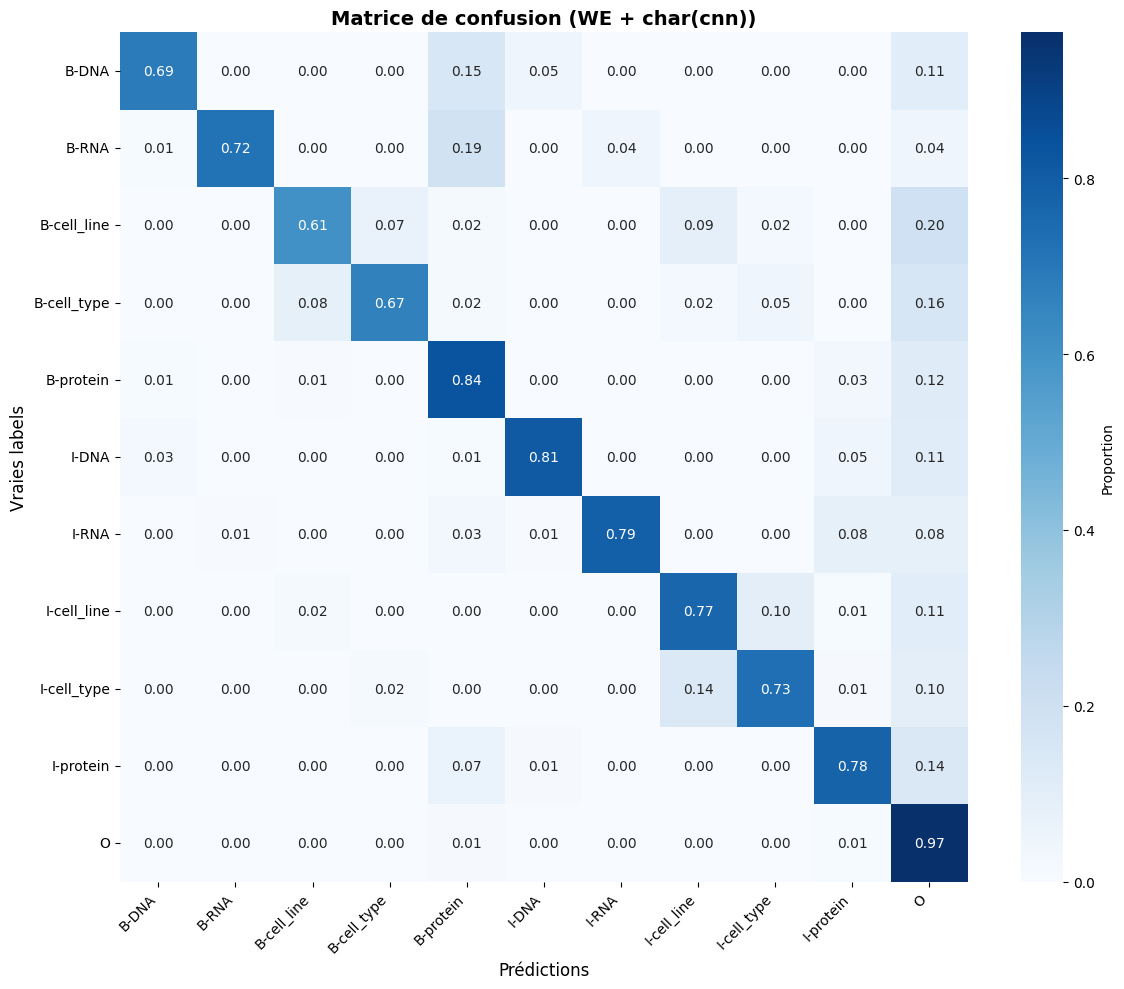

              precision    recall  f1-score   support

       B-DNA       0.72      0.69      0.70       857
       B-RNA       0.68      0.72      0.70        96
 B-cell_line       0.48      0.61      0.54       393
 B-cell_type       0.82      0.67      0.74      1730
   B-protein       0.73      0.84      0.78      4507
       I-DNA       0.80      0.81      0.80      1397
       I-RNA       0.72      0.79      0.75       156
 I-cell_line       0.49      0.77      0.60       792
 I-cell_type       0.86      0.73      0.79      2691
   I-protein       0.80      0.78      0.79      4222
           O       0.97      0.97      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.73      0.76      0.74     87803
weighted avg       0.93      0.93      0.93     87803



In [43]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn, predictions_we_char_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char_cnn) == set(targets_we_char_cnn) or all(isinstance(p, str) for p in predictions_we_char_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn,
        targets=targets_we_char_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn[:10])}")

## Combinaison 6:  WE + char(cnn) + attention

In [12]:
model_we_char_cnn_attention, history_we_char_cnn_attention = run_pipeline(
     dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,132,206


Training: 100%|██████████| 491/491 [08:02<00:00,  1.02it/s]


Epoch 01/40 | Train loss: 307.7944 | Dev loss: 171.7693 | P: 0.6972 R: 0.6756 F1: 0.6854 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6854


Training: 100%|██████████| 491/491 [07:26<00:00,  1.10it/s]


Epoch 02/40 | Train loss: 131.0212 | Dev loss: 143.9560 | P: 0.7197 R: 0.7027 F1: 0.7093 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7093


Training: 100%|██████████| 491/491 [07:24<00:00,  1.10it/s]


Epoch 03/40 | Train loss: 99.5946 | Dev loss: 134.6138 | P: 0.7258 R: 0.6955 F1: 0.7076 | LR: 0.000729


Training: 100%|██████████| 491/491 [07:44<00:00,  1.06it/s]


Epoch 04/40 | Train loss: 81.0664 | Dev loss: 129.8558 | P: 0.7402 R: 0.7061 F1: 0.7209 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7209


Training: 100%|██████████| 491/491 [07:48<00:00,  1.05it/s]


Epoch 05/40 | Train loss: 68.8351 | Dev loss: 130.2607 | P: 0.7377 R: 0.7193 F1: 0.7263 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7263


Training: 100%|██████████| 491/491 [07:52<00:00,  1.04it/s]


Epoch 06/40 | Train loss: 59.2744 | Dev loss: 132.7255 | P: 0.7427 R: 0.6999 F1: 0.7192 | LR: 0.000531


Training: 100%|██████████| 491/491 [08:18<00:00,  1.02s/it]


Epoch 07/40 | Train loss: 51.3007 | Dev loss: 139.3647 | P: 0.7347 R: 0.7033 F1: 0.7154 | LR: 0.000478


Training: 100%|██████████| 491/491 [07:50<00:00,  1.04it/s]


Epoch 08/40 | Train loss: 44.6175 | Dev loss: 146.1403 | P: 0.7467 R: 0.6778 F1: 0.7090 | LR: 0.000430


Training: 100%|██████████| 491/491 [09:06<00:00,  1.11s/it]


Epoch 09/40 | Train loss: 38.2353 | Dev loss: 151.7891 | P: 0.7260 R: 0.7067 F1: 0.7145 | LR: 0.000387
Early stopping triggered après 9 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 141.8288
Precision: 0.6684
Recall: 0.6872
F1-score: 0.6769


In [13]:
print_model_layers(model_we_char_cnn_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      436,224
attention_layer.W (Linear)     |          256
attention_projection (Linear)  |      131,328
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,132,206


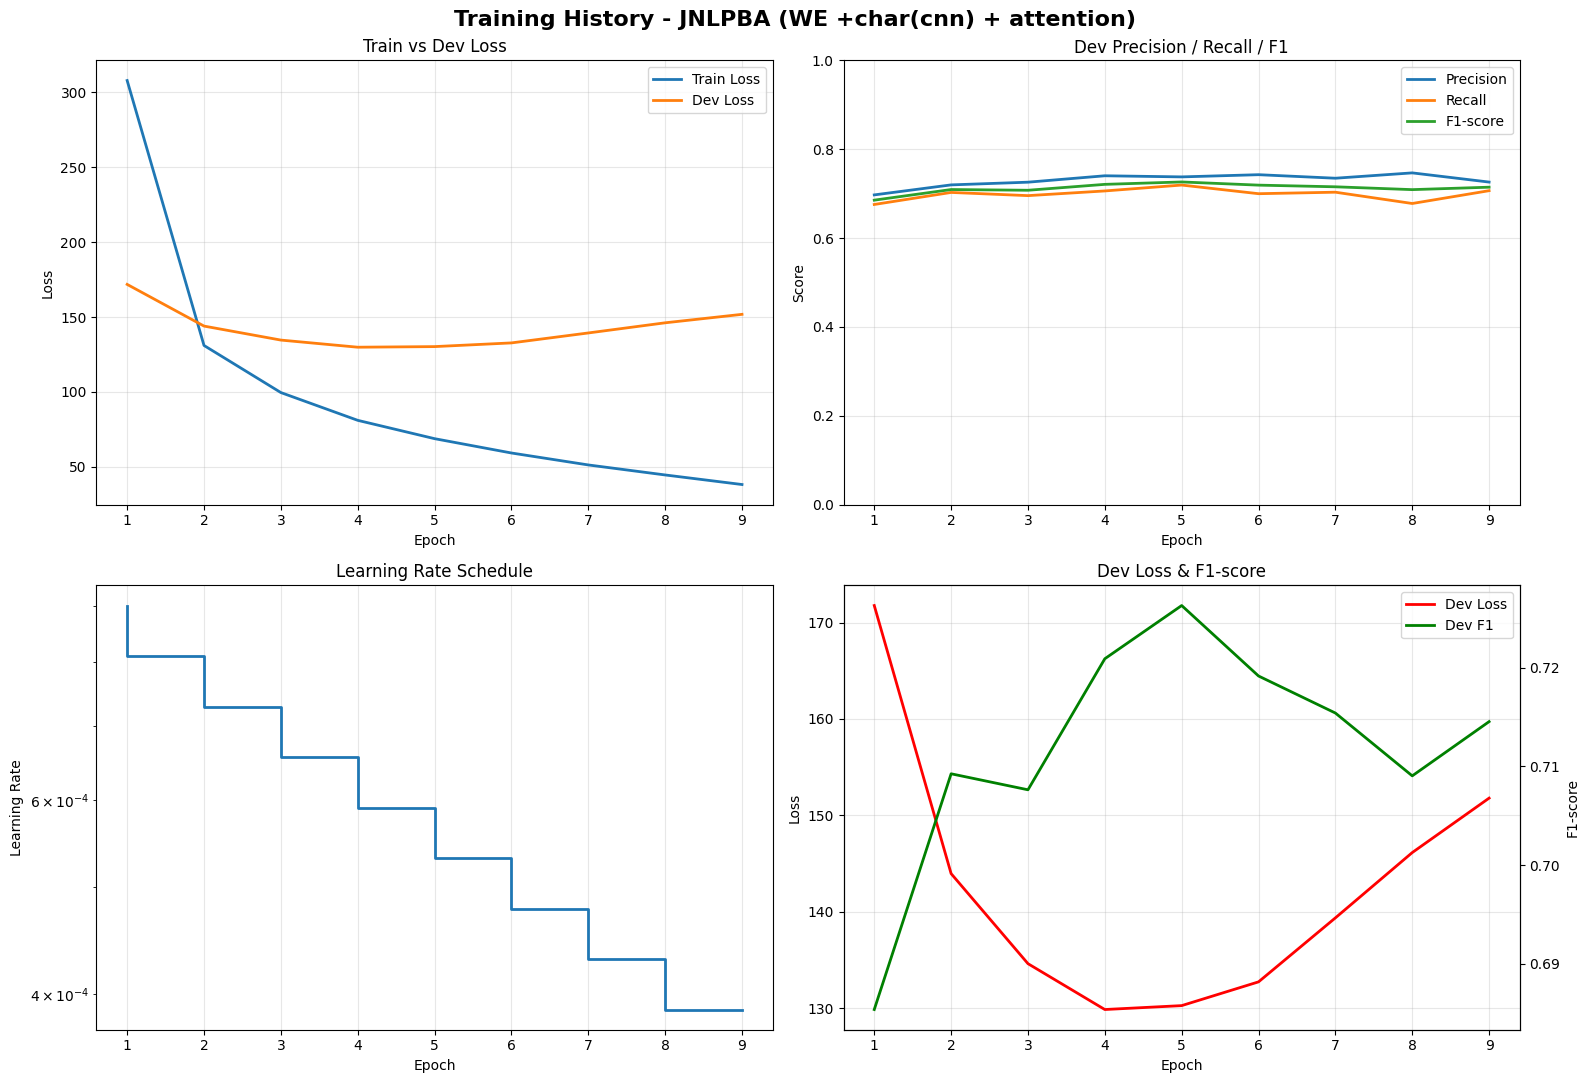


STATISTIQUES FINALES - JNLPBA (WE +char(cnn) + attention)
Meilleur F1 (dev)       : 0.7263
Meilleure Precision(dev): 0.7467
Meilleur Recall (dev)   : 0.7193
Final train loss        : 38.2353
Final dev loss          : 151.7891
Final learning rate     : 0.000387


In [14]:
plot_training_history(history_we_char_cnn_attention, dataset_name="JNLPBA (WE +char(cnn) + attention)")

In [15]:
model_path = "./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt"
model_we_char_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char_cnn_attention, targets_we_char_cnn_attention = predict_on_test_set(
    model=model_we_char_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_cnn_attention/best_model.pt
Best F1 enregistré: 0.7263
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O        


Accuracy globale: 0.9308

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'O', 'B-RNA', 'I-cell_line', 'I-DNA', 'I-protein', 'B-protein', 'B-cell_type', 'B-cell_line', 'B-DNA', 'I-RNA', 'I-cell_type'}
  Unique entity tags in predictions: {'O', 'B-RNA', 'I-cell_line', 'I-DNA', 'I-protein', 'B-protein', 'B-cell_type', 'B-cell_line', 'B-DNA', 'I-RNA', 'I-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


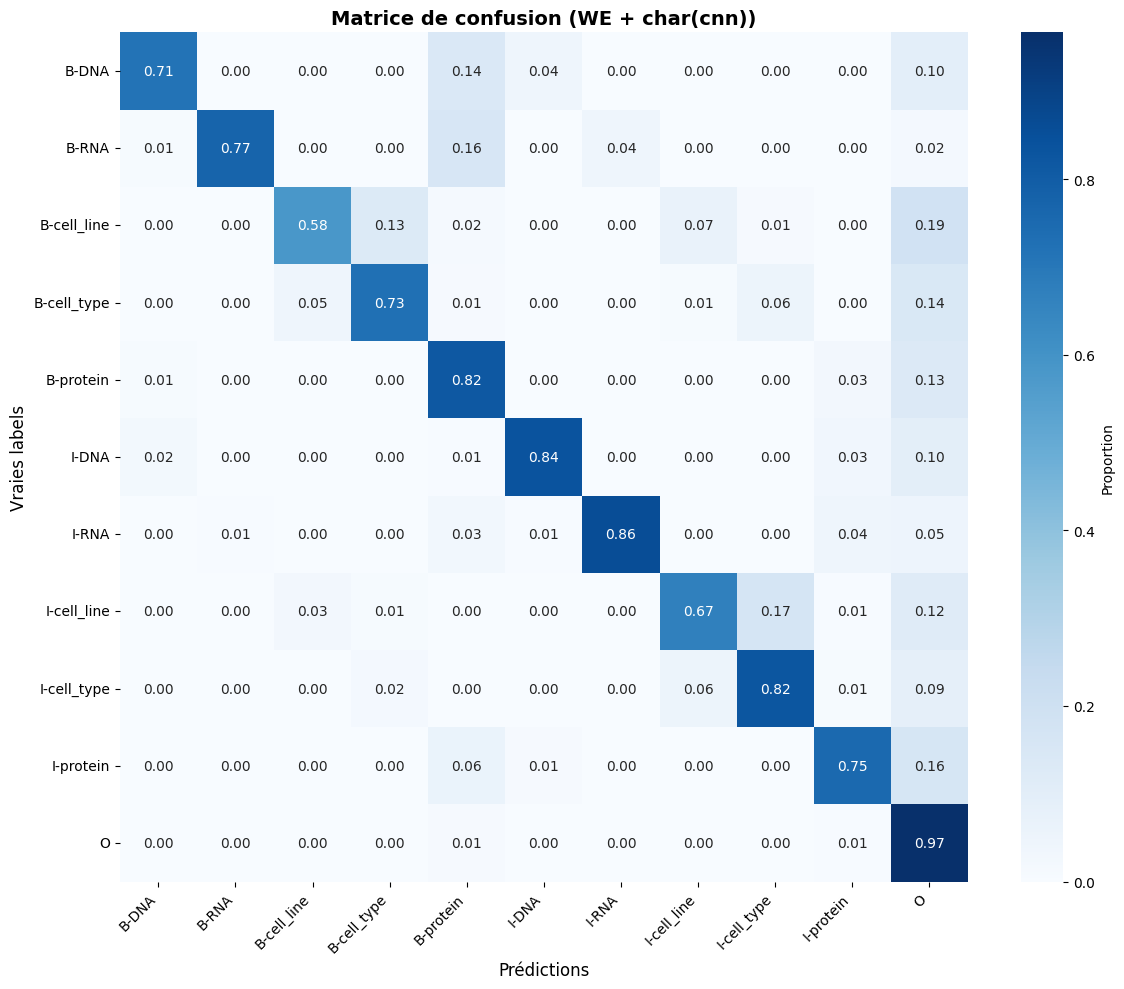

              precision    recall  f1-score   support

       B-DNA       0.72      0.71      0.71       857
       B-RNA       0.70      0.77      0.73        96
 B-cell_line       0.57      0.58      0.58       393
 B-cell_type       0.79      0.73      0.76      1730
   B-protein       0.74      0.82      0.78      4507
       I-DNA       0.80      0.84      0.82      1397
       I-RNA       0.76      0.86      0.80       156
 I-cell_line       0.64      0.67      0.66       792
 I-cell_type       0.83      0.82      0.82      2691
   I-protein       0.81      0.75      0.78      4222
           O       0.97      0.97      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.76      0.78      0.76     87803
weighted avg       0.93      0.93      0.93     87803



In [ ]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn_attention, predictions_we_char_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char_cnn_attention) == set(targets_we_char_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn_attention,
        targets=targets_we_char_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn_attention[:10])}")

## Combinaison 7: WE + char(cnn, bilstm)

In [17]:
model_we_char_cnn_bilstm, history_we_char_cnn_bilstm = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,148,072


Training: 100%|██████████| 491/491 [02:11<00:00,  3.73it/s]


Epoch 01/40 | Train loss: 317.3573 | Dev loss: 170.8941 | P: 0.7285 R: 0.6584 F1: 0.6868 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6868


Training: 100%|██████████| 491/491 [04:11<00:00,  1.96it/s]


Epoch 02/40 | Train loss: 130.5952 | Dev loss: 155.1541 | P: 0.7237 R: 0.7027 F1: 0.7066 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7066


Training: 100%|██████████| 491/491 [02:17<00:00,  3.58it/s]


Epoch 03/40 | Train loss: 99.8747 | Dev loss: 137.5858 | P: 0.7350 R: 0.7134 F1: 0.7213 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7213


Training: 100%|██████████| 491/491 [03:13<00:00,  2.54it/s]


Epoch 04/40 | Train loss: 82.2650 | Dev loss: 127.6640 | P: 0.7404 R: 0.7088 F1: 0.7214 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7214


Training: 100%|██████████| 491/491 [04:33<00:00,  1.80it/s]


Epoch 05/40 | Train loss: 69.6850 | Dev loss: 129.0333 | P: 0.7431 R: 0.7023 F1: 0.7192 | LR: 0.000590


Training: 100%|██████████| 491/491 [03:12<00:00,  2.55it/s]


Epoch 06/40 | Train loss: 60.3836 | Dev loss: 132.5488 | P: 0.7529 R: 0.6830 F1: 0.7129 | LR: 0.000531


Training: 100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 07/40 | Train loss: 53.3493 | Dev loss: 129.3409 | P: 0.7481 R: 0.6881 F1: 0.7137 | LR: 0.000478


Training: 100%|██████████| 491/491 [02:13<00:00,  3.67it/s]


Epoch 08/40 | Train loss: 47.0512 | Dev loss: 132.1228 | P: 0.7412 R: 0.6976 F1: 0.7172 | LR: 0.000430
Early stopping triggered après 8 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 136.3961
Precision: 0.6705
Recall: 0.6833
F1-score: 0.6757


In [35]:
print_model_layers(model_we_char_cnn_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      538,624
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,148,072


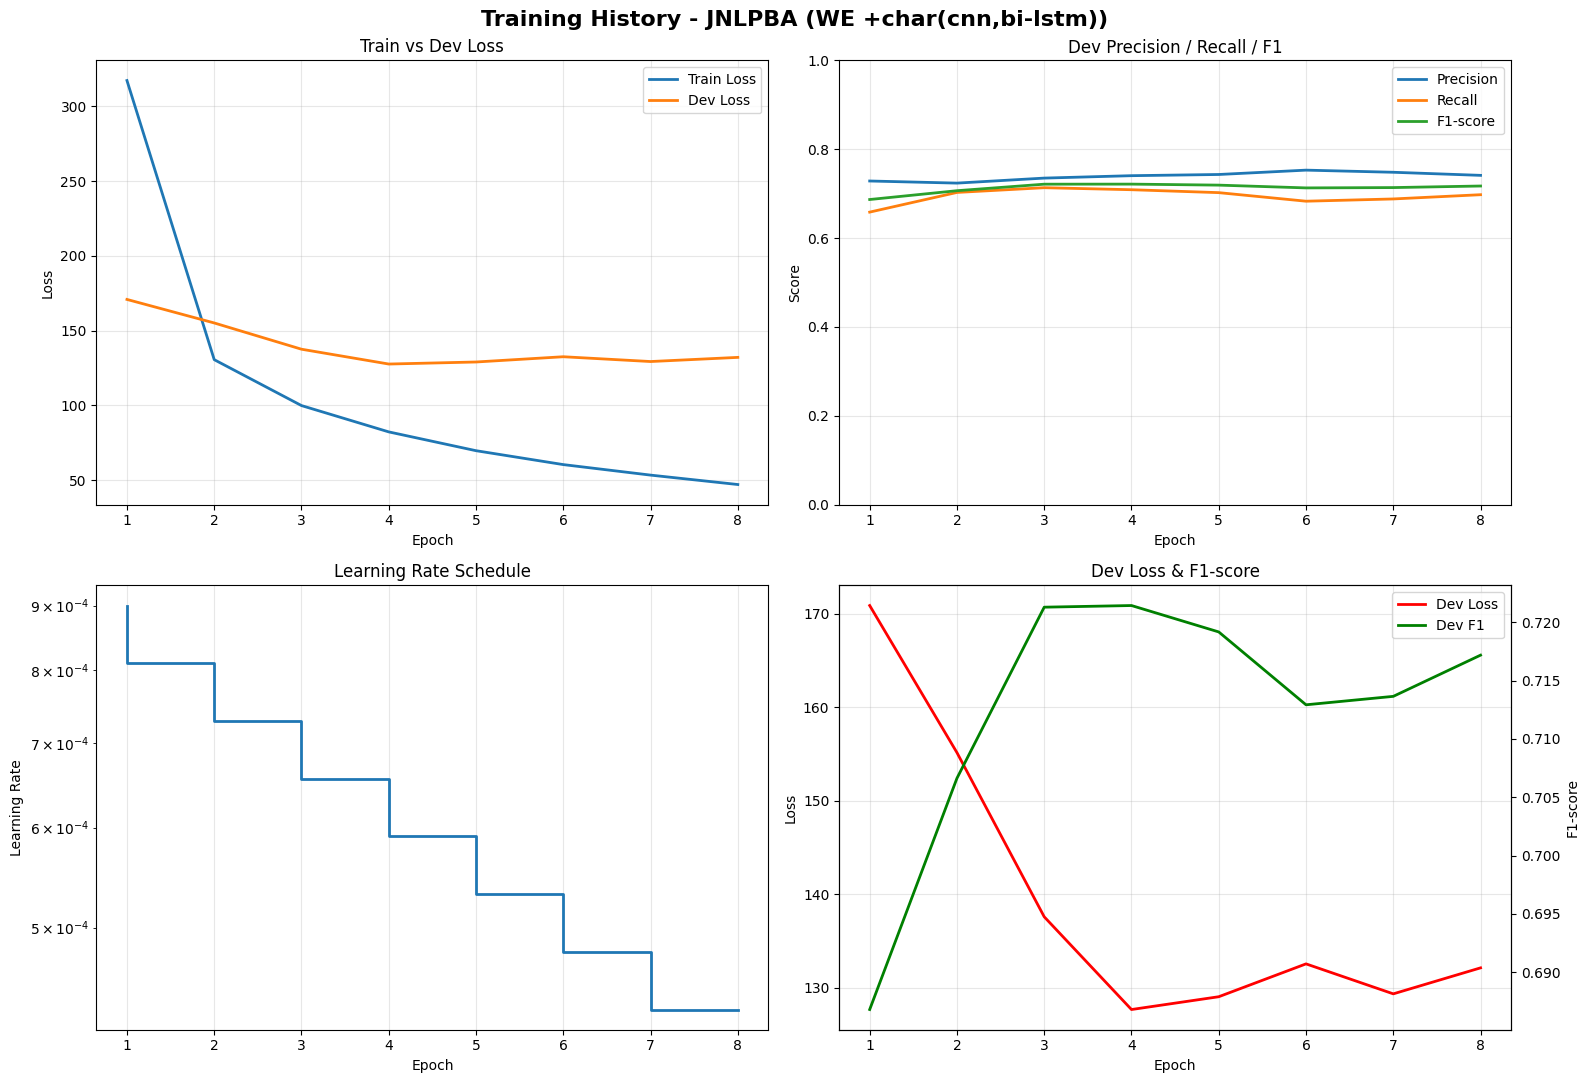


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bi-lstm))
Meilleur F1 (dev)       : 0.7214
Meilleure Precision(dev): 0.7529
Meilleur Recall (dev)   : 0.7134
Final train loss        : 47.0512
Final dev loss          : 132.1228
Final learning rate     : 0.000430


In [18]:
plot_training_history(history_we_char_cnn_bilstm, dataset_name="JNLPBA (WE +char(cnn,bi-lstm))")

In [19]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt"
model_we_char__bilstm_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn = predict_on_test_set(
    model=model_we_char__bilstm_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt
Best F1 enregistré: 0.7214
Époque: 3
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O           


Accuracy globale: 0.9303

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'O', 'B-RNA', 'I-cell_line', 'I-DNA', 'I-protein', 'B-protein', 'B-cell_type', 'B-cell_line', 'B-DNA', 'I-RNA', 'I-cell_type'}
  Unique entity tags in predictions: {'O', 'B-RNA', 'I-cell_line', 'I-DNA', 'I-protein', 'B-protein', 'B-cell_type', 'B-cell_line', 'B-DNA', 'I-RNA', 'I-cell_type'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


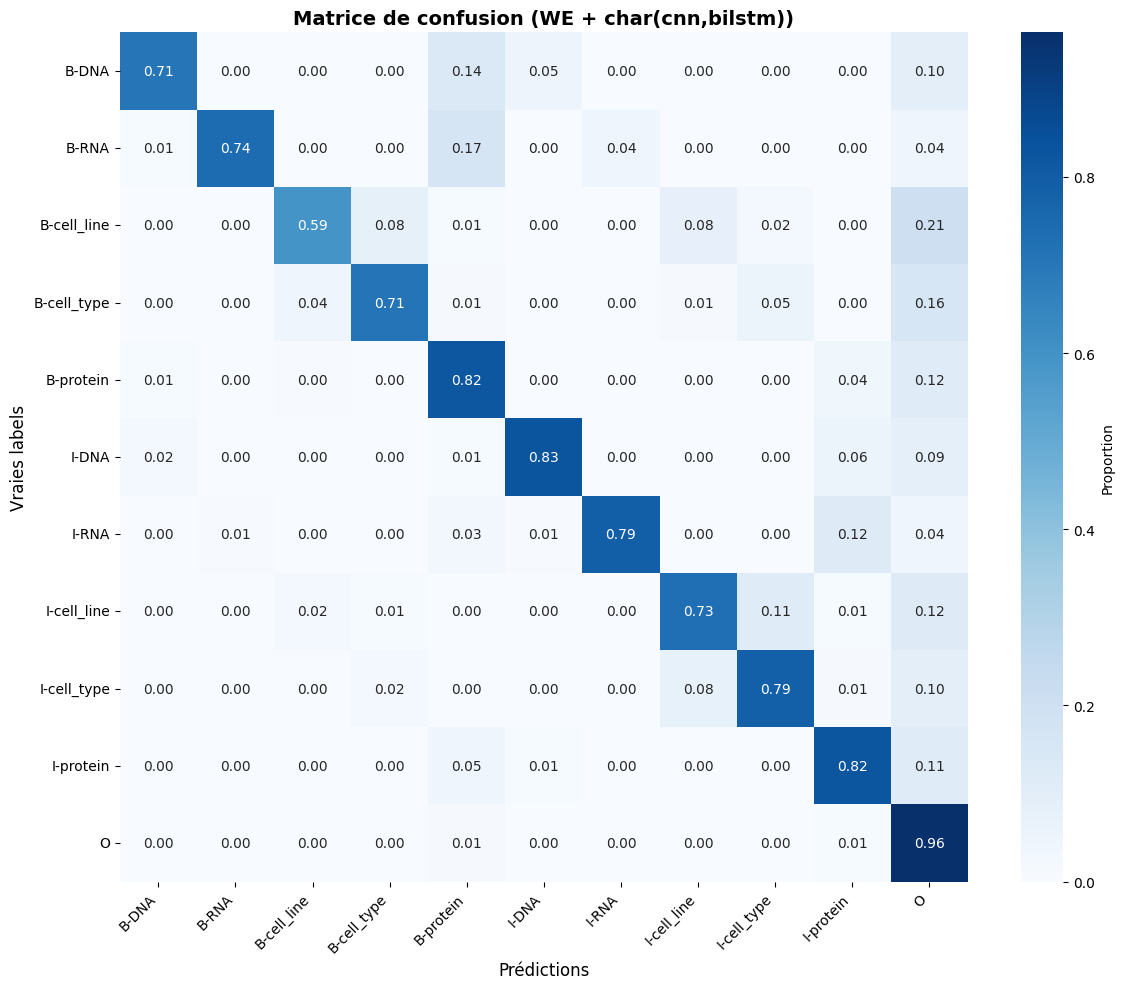

              precision    recall  f1-score   support

       B-DNA       0.73      0.71      0.72       857
       B-RNA       0.74      0.74      0.74        96
 B-cell_line       0.58      0.59      0.58       393
 B-cell_type       0.81      0.71      0.75      1730
   B-protein       0.75      0.82      0.78      4507
       I-DNA       0.79      0.83      0.81      1397
       I-RNA       0.77      0.79      0.78       156
 I-cell_line       0.60      0.73      0.66       792
 I-cell_type       0.84      0.79      0.81      2691
   I-protein       0.76      0.82      0.79      4222
           O       0.97      0.96      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.76      0.77      0.76     87803
weighted avg       0.93      0.93      0.93     87803



In [20]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn, predictions_we_char__bilstm_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']

if set(predictions_we_char__bilstm_cnn) == set(targets_we_char__bilstm_cnn) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn,
        targets=targets_we_char__bilstm_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn[:10])}")

## Combinaison 8: WE + char(cnn, bilstm) + attention

In [12]:
model_we_char_cnn_bilstm_attention, history_we_char_cnn_bilstm_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,279,656


Training: 100%|██████████| 491/491 [08:34<00:00,  1.05s/it]


Epoch 01/40 | Train loss: 300.2389 | Dev loss: 196.6698 | P: 0.7280 R: 0.6185 F1: 0.6599 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6599


Training: 100%|██████████| 491/491 [08:27<00:00,  1.03s/it]


Epoch 02/40 | Train loss: 128.7719 | Dev loss: 142.1810 | P: 0.7344 R: 0.6949 F1: 0.7114 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7114


Training: 100%|██████████| 491/491 [08:42<00:00,  1.06s/it]


Epoch 03/40 | Train loss: 97.7186 | Dev loss: 133.1148 | P: 0.7459 R: 0.6992 F1: 0.7207 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7207


Training: 100%|██████████| 491/491 [08:35<00:00,  1.05s/it]


Epoch 04/40 | Train loss: 79.6356 | Dev loss: 128.1193 | P: 0.7516 R: 0.6945 F1: 0.7213 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7213


Training: 100%|██████████| 491/491 [08:29<00:00,  1.04s/it]


Epoch 05/40 | Train loss: 66.4539 | Dev loss: 130.1966 | P: 0.7556 R: 0.6863 F1: 0.7179 | LR: 0.000590


Training: 100%|██████████| 491/491 [08:29<00:00,  1.04s/it]


Epoch 06/40 | Train loss: 56.1827 | Dev loss: 130.3906 | P: 0.7482 R: 0.7027 F1: 0.7230 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7230


Training: 100%|██████████| 491/491 [08:31<00:00,  1.04s/it]


Epoch 07/40 | Train loss: 47.6777 | Dev loss: 138.9817 | P: 0.7588 R: 0.6672 F1: 0.7075 | LR: 0.000478


Training: 100%|██████████| 491/491 [09:02<00:00,  1.11s/it]


Epoch 08/40 | Train loss: 40.7810 | Dev loss: 142.2662 | P: 0.7522 R: 0.6796 F1: 0.7118 | LR: 0.000430


Training: 100%|██████████| 491/491 [08:45<00:00,  1.07s/it]


Epoch 09/40 | Train loss: 33.9398 | Dev loss: 155.5108 | P: 0.7469 R: 0.6737 F1: 0.7068 | LR: 0.000387


Training: 100%|██████████| 491/491 [09:09<00:00,  1.12s/it]


Epoch 10/40 | Train loss: 28.4230 | Dev loss: 163.9095 | P: 0.7333 R: 0.6944 F1: 0.7118 | LR: 0.000349
Early stopping triggered après 10 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 145.0069
Precision: 0.6682
Recall: 0.6653
F1-score: 0.6654


In [13]:
print_model_layers(model_we_char_cnn_bilstm_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      538,624
attention_layer.W (Linear)     |          256
attention_projection (Linear)  |      131,328
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,279,656


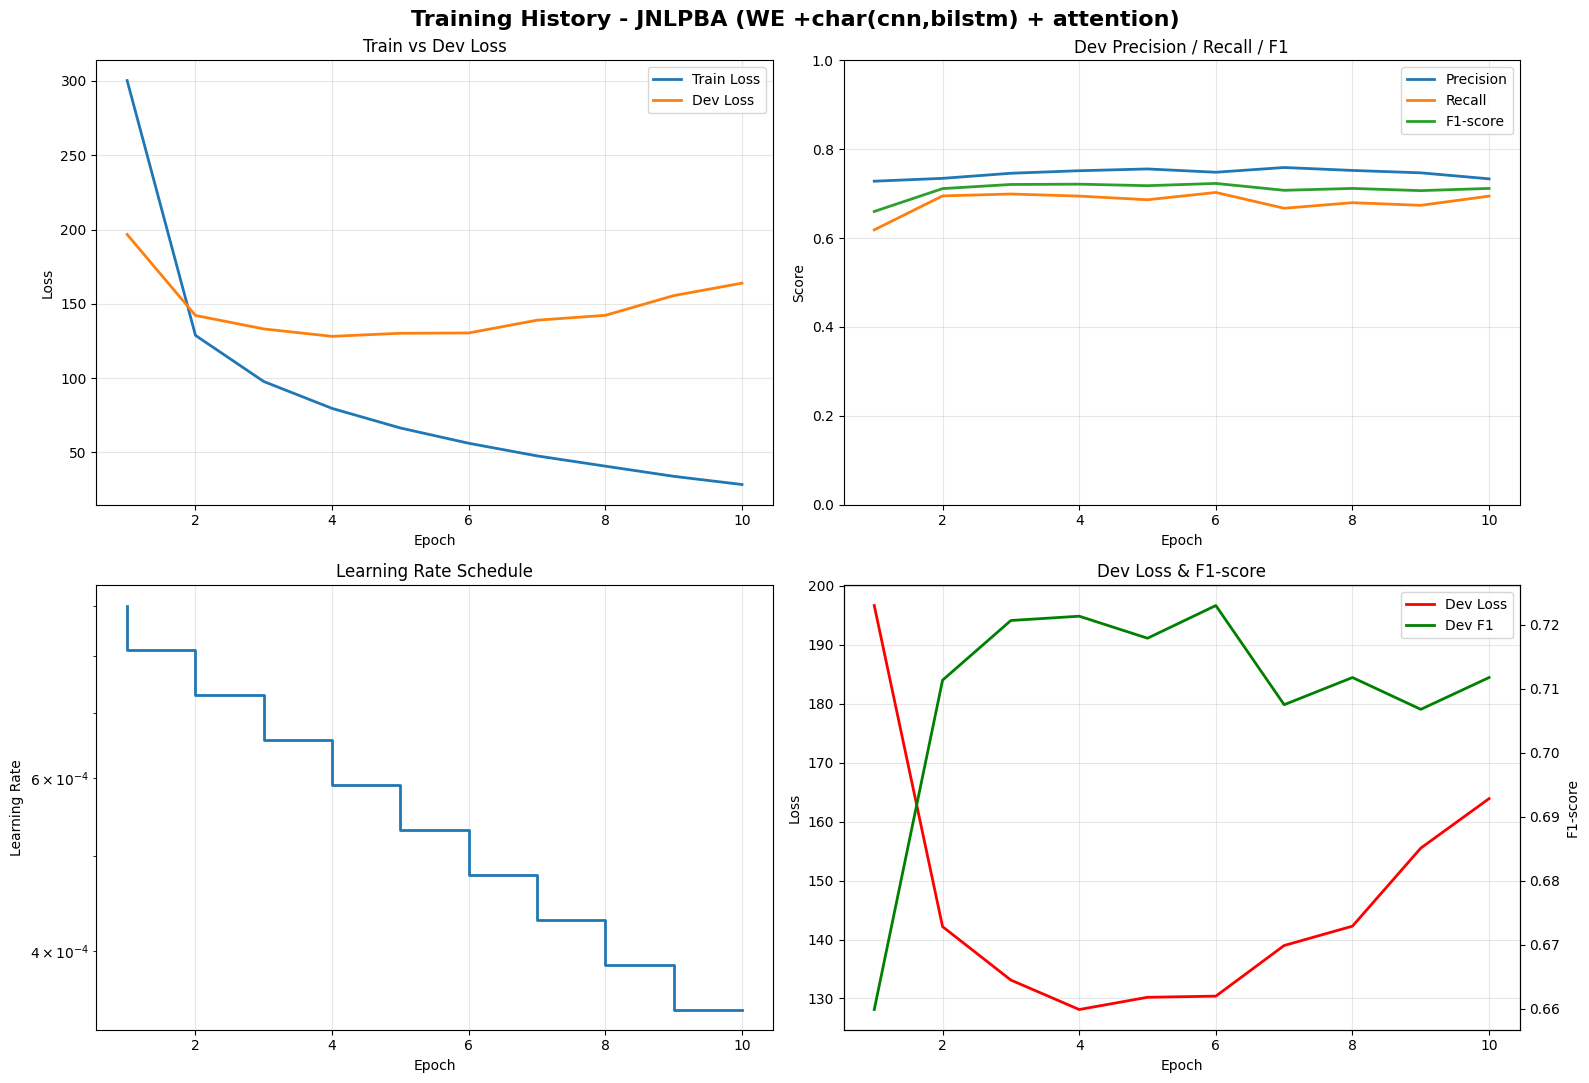


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + attention)
Meilleur F1 (dev)       : 0.7230
Meilleure Precision(dev): 0.7588
Meilleur Recall (dev)   : 0.7027
Final train loss        : 28.4230
Final dev loss          : 163.9095
Final learning rate     : 0.000349


In [14]:
plot_training_history(history_we_char_cnn_bilstm_attention, dataset_name="JNLPBA (WE +char(cnn,bilstm) + attention)")

In [15]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt"
model_we_char__bilstm_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt
Best F1 enregistré: 0.7230
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-protein          incorrect
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O   


Accuracy globale: 0.9290

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'I-cell_line', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-cell_type', 'I-protein', 'O', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'B-RNA', 'I-DNA', 'I-RNA', 'B-cell_type', 'B-cell_line', 'B-protein', 'I-cell_type', 'I-protein', 'O', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


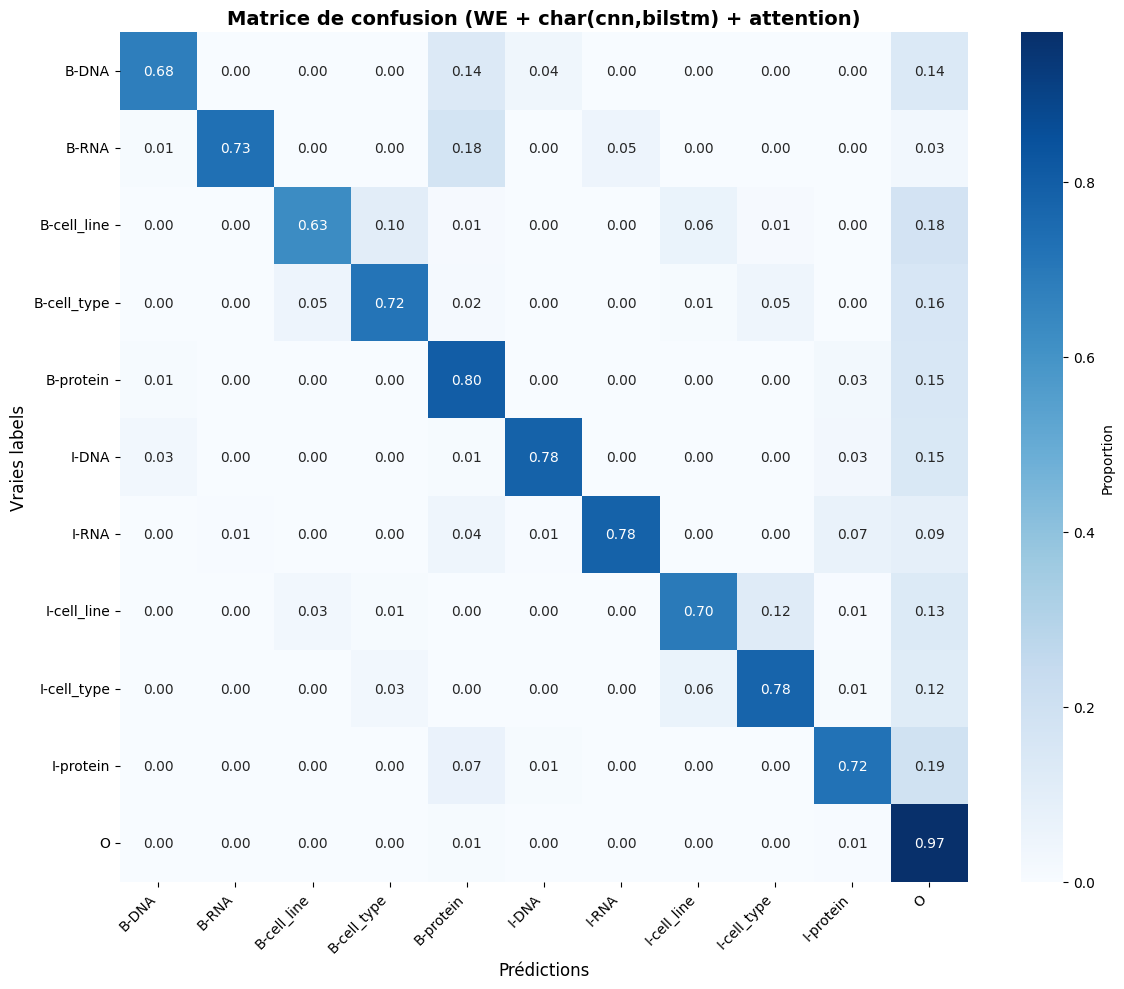

              precision    recall  f1-score   support

       B-DNA       0.72      0.68      0.70       857
       B-RNA       0.66      0.73      0.69        96
 B-cell_line       0.55      0.63      0.58       393
 B-cell_type       0.78      0.72      0.75      1730
   B-protein       0.74      0.80      0.77      4507
       I-DNA       0.83      0.78      0.80      1397
       I-RNA       0.74      0.78      0.76       156
 I-cell_line       0.65      0.70      0.67       792
 I-cell_type       0.86      0.78      0.81      2691
   I-protein       0.82      0.72      0.77      4222
           O       0.96      0.97      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.76      0.75      0.75     87803
weighted avg       0.93      0.93      0.93     87803



In [16]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention, predictions_we_char__bilstm_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")


if set(predictions_we_char__bilstm_cnn_attention) == set(targets_we_char__bilstm_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention,
        targets=targets_we_char__bilstm_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention[:10])}")

## Combinaison 9 : WE + char(cnn, bilstm) + fully connected network

In [17]:
model_we_char_cnn_bilstm_fc, history_we_char_cnn_bilstm_fc = run_pipeline(
     dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=True,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,026,768


Training: 100%|██████████| 491/491 [02:26<00:00,  3.36it/s]


Epoch 01/40 | Train loss: 329.0800 | Dev loss: 173.6073 | P: 0.7335 R: 0.6414 F1: 0.6796 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6796


Training: 100%|██████████| 491/491 [03:19<00:00,  2.47it/s]


Epoch 02/40 | Train loss: 135.5299 | Dev loss: 146.9795 | P: 0.7392 R: 0.6716 F1: 0.7032 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7032


Training: 100%|██████████| 491/491 [03:22<00:00,  2.42it/s]


Epoch 03/40 | Train loss: 106.1357 | Dev loss: 134.3797 | P: 0.7324 R: 0.7149 F1: 0.7212 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7212


Training: 100%|██████████| 491/491 [03:05<00:00,  2.65it/s]


Epoch 04/40 | Train loss: 90.1432 | Dev loss: 131.1997 | P: 0.7356 R: 0.7000 F1: 0.7150 | LR: 0.000656


Training: 100%|██████████| 491/491 [03:13<00:00,  2.53it/s]


Epoch 05/40 | Train loss: 79.4638 | Dev loss: 126.9736 | P: 0.7401 R: 0.7090 F1: 0.7229 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7229


Training: 100%|██████████| 491/491 [03:03<00:00,  2.68it/s]


Epoch 06/40 | Train loss: 71.6517 | Dev loss: 127.5746 | P: 0.7327 R: 0.6877 F1: 0.7060 | LR: 0.000531


Training: 100%|██████████| 491/491 [03:12<00:00,  2.56it/s]


Epoch 07/40 | Train loss: 65.8851 | Dev loss: 123.8695 | P: 0.7266 R: 0.7006 F1: 0.7104 | LR: 0.000478


Training: 100%|██████████| 491/491 [02:52<00:00,  2.84it/s]


Epoch 08/40 | Train loss: 60.8297 | Dev loss: 125.5392 | P: 0.7321 R: 0.7121 F1: 0.7199 | LR: 0.000430


Training: 100%|██████████| 491/491 [02:49<00:00,  2.89it/s]


Epoch 09/40 | Train loss: 56.6444 | Dev loss: 126.0598 | P: 0.7331 R: 0.6880 F1: 0.7081 | LR: 0.000387
Early stopping triggered après 9 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 135.7252
Precision: 0.6657
Recall: 0.6834
F1-score: 0.6722


In [18]:
print_model_layers(model_we_char_cnn_bilstm_fc)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (Dropout)             |            0
context_lstm (LSTM)            |      337,920
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,026,768


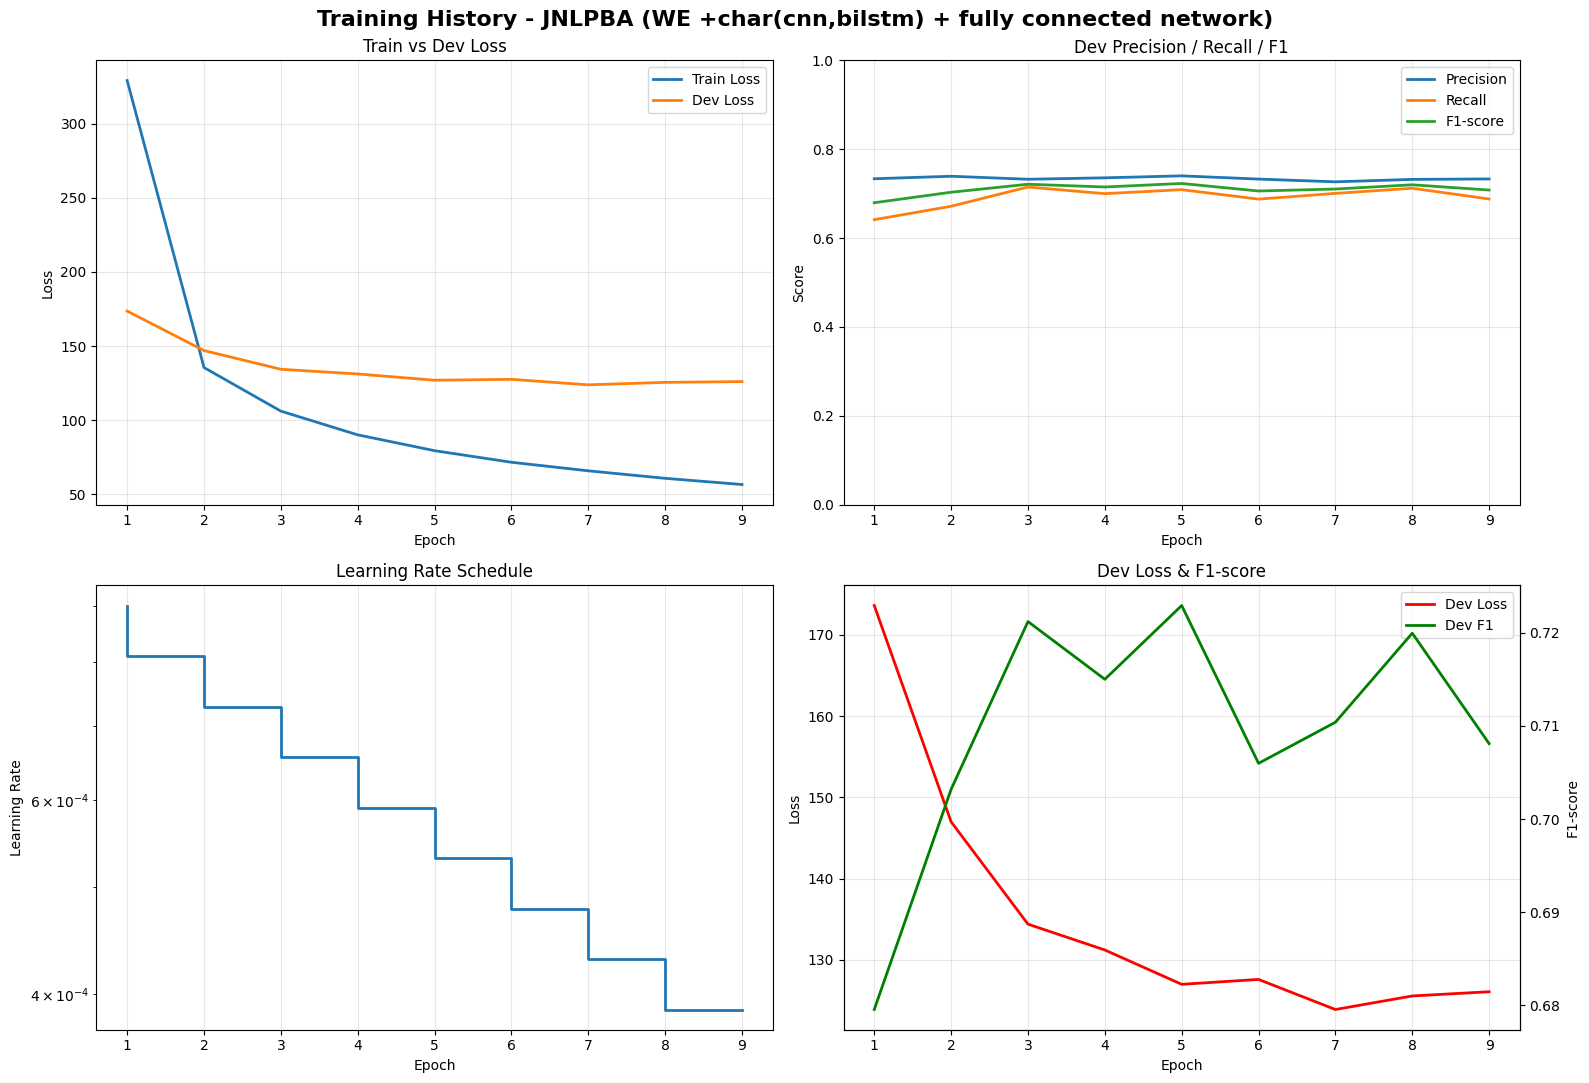


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + fully connected network)
Meilleur F1 (dev)       : 0.7229
Meilleure Precision(dev): 0.7401
Meilleur Recall (dev)   : 0.7149
Final train loss        : 56.6444
Final dev loss          : 126.0598
Final learning rate     : 0.000387


In [19]:
plot_training_history(history_we_char_cnn_bilstm_fc, dataset_name="JNLPBA (WE +char(cnn,bilstm) + fully connected network)")

In [20]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_fc/best_model.pt"
model_we_char__bilstm_cnn_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=True
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_fc/best_model.pt
Best F1 enregistré: 0.7229
Époque: 4
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O        


Accuracy globale: 0.9290

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'I-cell_line', 'B-RNA', 'I-RNA', 'I-DNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-cell_type', 'I-protein', 'O', 'B-DNA'}
  Unique entity tags in predictions: {'I-cell_line', 'B-RNA', 'I-DNA', 'I-RNA', 'B-cell_type', 'B-cell_line', 'B-protein', 'I-cell_type', 'I-protein', 'O', 'B-DNA'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


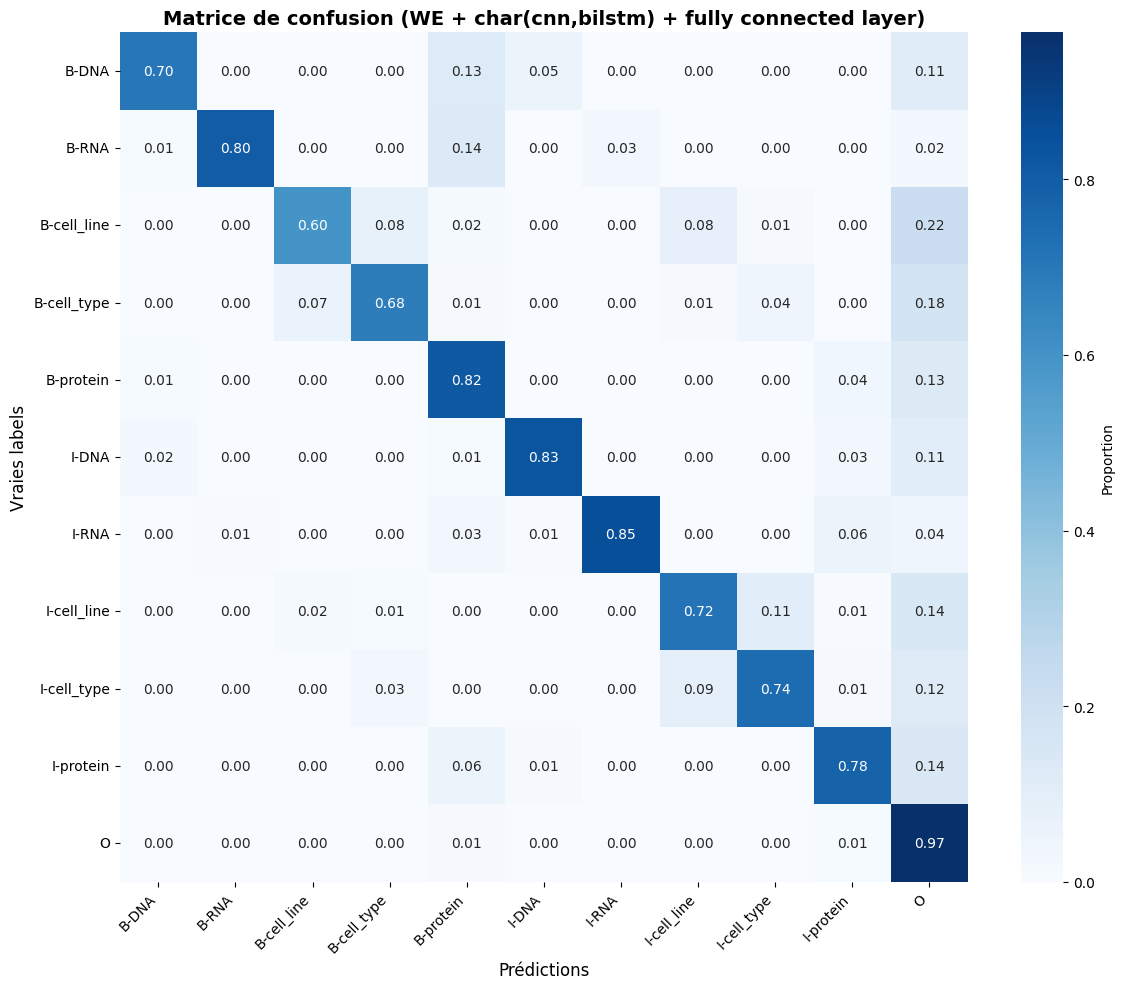

              precision    recall  f1-score   support

       B-DNA       0.72      0.70      0.71       857
       B-RNA       0.70      0.80      0.75        96
 B-cell_line       0.53      0.60      0.56       393
 B-cell_type       0.81      0.68      0.74      1730
   B-protein       0.74      0.82      0.78      4507
       I-DNA       0.79      0.83      0.81      1397
       I-RNA       0.78      0.85      0.81       156
 I-cell_line       0.60      0.72      0.65       792
 I-cell_type       0.87      0.74      0.80      2691
   I-protein       0.79      0.78      0.78      4222
           O       0.97      0.97      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.75      0.77      0.76     87803
weighted avg       0.93      0.93      0.93     87803



In [21]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_fc, predictions_we_char__bilstm_cnn_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char__bilstm_cnn_fc) == set(targets_we_char__bilstm_cnn_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_fc,
        targets=targets_we_char__bilstm_cnn_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + fully connected layer)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_fc[:10])}")

## Combinaison 10 : WE + char(cnn, bilstm) + fully connected network + attention

In [11]:
model_we_char_cnn_bilstm_fc_attention, history_we_char_cnn_bilstm_fc_attention = run_pipeline(
     dataset_name='JNLPBA',
    loaders=results_jnlpba,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/JNLPBA"
)

Model parameters: 3,158,352


Training: 100%|██████████| 491/491 [09:45<00:00,  1.19s/it]


Epoch 01/40 | Train loss: 334.1010 | Dev loss: 171.5534 | P: 0.7167 R: 0.6699 F1: 0.6888 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6888


Training: 100%|██████████| 491/491 [09:18<00:00,  1.14s/it]


Epoch 02/40 | Train loss: 141.6505 | Dev loss: 153.8236 | P: 0.7448 R: 0.6717 F1: 0.7020 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.7020


Training: 100%|██████████| 491/491 [09:15<00:00,  1.13s/it]


Epoch 03/40 | Train loss: 110.0901 | Dev loss: 138.5448 | P: 0.7357 R: 0.6969 F1: 0.7104 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7104


Training: 100%|██████████| 491/491 [09:42<00:00,  1.19s/it]


Epoch 04/40 | Train loss: 92.8216 | Dev loss: 131.4273 | P: 0.7471 R: 0.6943 F1: 0.7176 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7176


Training: 100%|██████████| 491/491 [08:59<00:00,  1.10s/it]


Epoch 05/40 | Train loss: 80.8006 | Dev loss: 130.4543 | P: 0.7228 R: 0.7156 F1: 0.7173 | LR: 0.000590


Training: 100%|██████████| 491/491 [08:58<00:00,  1.10s/it]


Epoch 06/40 | Train loss: 72.7617 | Dev loss: 128.7970 | P: 0.7356 R: 0.7117 F1: 0.7202 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7202


Training: 100%|██████████| 491/491 [08:57<00:00,  1.09s/it]


Epoch 07/40 | Train loss: 65.6159 | Dev loss: 125.7259 | P: 0.7304 R: 0.7201 F1: 0.7232 | LR: 0.000478
Meilleur modèle sauvegardé: F1 0.7232


Training: 100%|██████████| 491/491 [09:12<00:00,  1.12s/it]


Epoch 08/40 | Train loss: 59.9528 | Dev loss: 131.9961 | P: 0.7543 R: 0.6496 F1: 0.6955 | LR: 0.000430


Training: 100%|██████████| 491/491 [09:49<00:00,  1.20s/it]


Epoch 09/40 | Train loss: 55.4212 | Dev loss: 124.4151 | P: 0.7285 R: 0.7210 F1: 0.7241 | LR: 0.000387
Meilleur modèle sauvegardé: F1 0.7241


Training: 100%|██████████| 491/491 [09:50<00:00,  1.20s/it]


Epoch 10/40 | Train loss: 50.9730 | Dev loss: 130.2165 | P: 0.7376 R: 0.7084 F1: 0.7214 | LR: 0.000349


Training: 100%|██████████| 491/491 [09:56<00:00,  1.21s/it]


Epoch 11/40 | Train loss: 47.9161 | Dev loss: 136.3223 | P: 0.7383 R: 0.6878 F1: 0.7106 | LR: 0.000314


Training: 100%|██████████| 491/491 [09:58<00:00,  1.22s/it]


Epoch 12/40 | Train loss: 44.7148 | Dev loss: 133.4471 | P: 0.7389 R: 0.6978 F1: 0.7168 | LR: 0.000282


Training: 100%|██████████| 491/491 [09:50<00:00,  1.20s/it]


Epoch 13/40 | Train loss: 42.0929 | Dev loss: 140.3727 | P: 0.7310 R: 0.6985 F1: 0.7129 | LR: 0.000254
Early stopping triggered après 13 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 140.4000
Precision: 0.6528
Recall: 0.6795
F1-score: 0.6633


In [12]:
print_model_layers(model_we_char_cnn_bilstm_fc_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    2,532,800
char_cnn.char_embedding (Embedding) |        4,250
char_cnn.convs.0 (Conv1d)      |        4,832
char_cnn.convs.1 (Conv1d)      |        8,032
char_cnn.convs.2 (Conv1d)      |       11,232
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,250
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (Dropout)             |            0
context_lstm (LSTM)            |      337,920
attention_layer.W (Linear)     |          256
attention_projection (Linear)  |      131,328
emission (Linear)              |        3,084
crf (CRF)                      |          168
---------------------------------------------
Total parameters               |    3,158,352


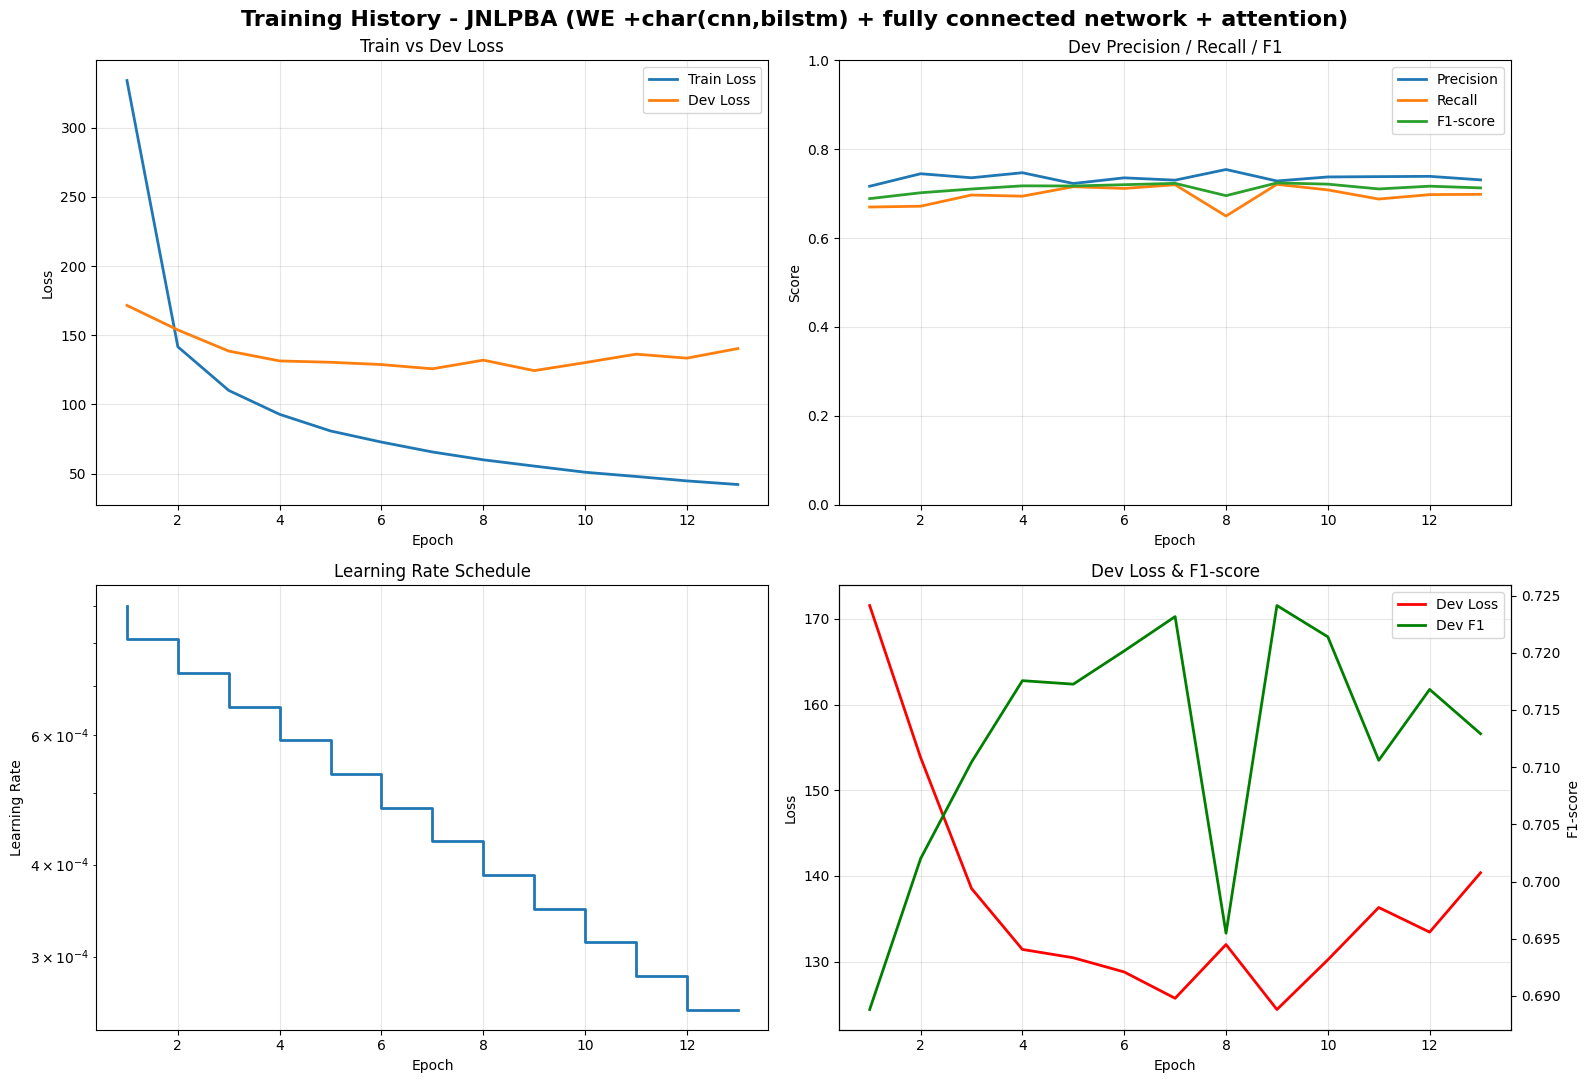


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + fully connected network + attention)
Meilleur F1 (dev)       : 0.7241
Meilleure Precision(dev): 0.7543
Meilleur Recall (dev)   : 0.7210
Final train loss        : 42.0929
Final dev loss          : 140.3727
Final learning rate     : 0.000254


In [13]:
plot_training_history(history_we_char_cnn_bilstm_fc_attention, dataset_name="JNLPBA (WE +char(cnn,bilstm) + fully connected network + attention)")

In [14]:
model_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt"
model_we_char__bilstm_cnn_attention_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)
test_loader = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt
Best F1 enregistré: 0.7241
Époque: 8
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  |


Accuracy globale: 0.9267

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: O

Statistiques:
  Total tokens: 87803
  Entity tokens: 87803
  Unique entity tags in targets: {'O', 'B-protein', 'I-cell_type', 'I-RNA', 'I-DNA', 'B-RNA', 'B-DNA', 'B-cell_type', 'I-cell_line', 'I-protein', 'B-cell_line'}
  Unique entity tags in predictions: {'O', 'B-protein', 'I-DNA', 'I-cell_type', 'I-RNA', 'B-DNA', 'B-RNA', 'B-cell_type', 'I-cell_line', 'I-protein', 'B-cell_line'}
  Tags valides à plotter: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']


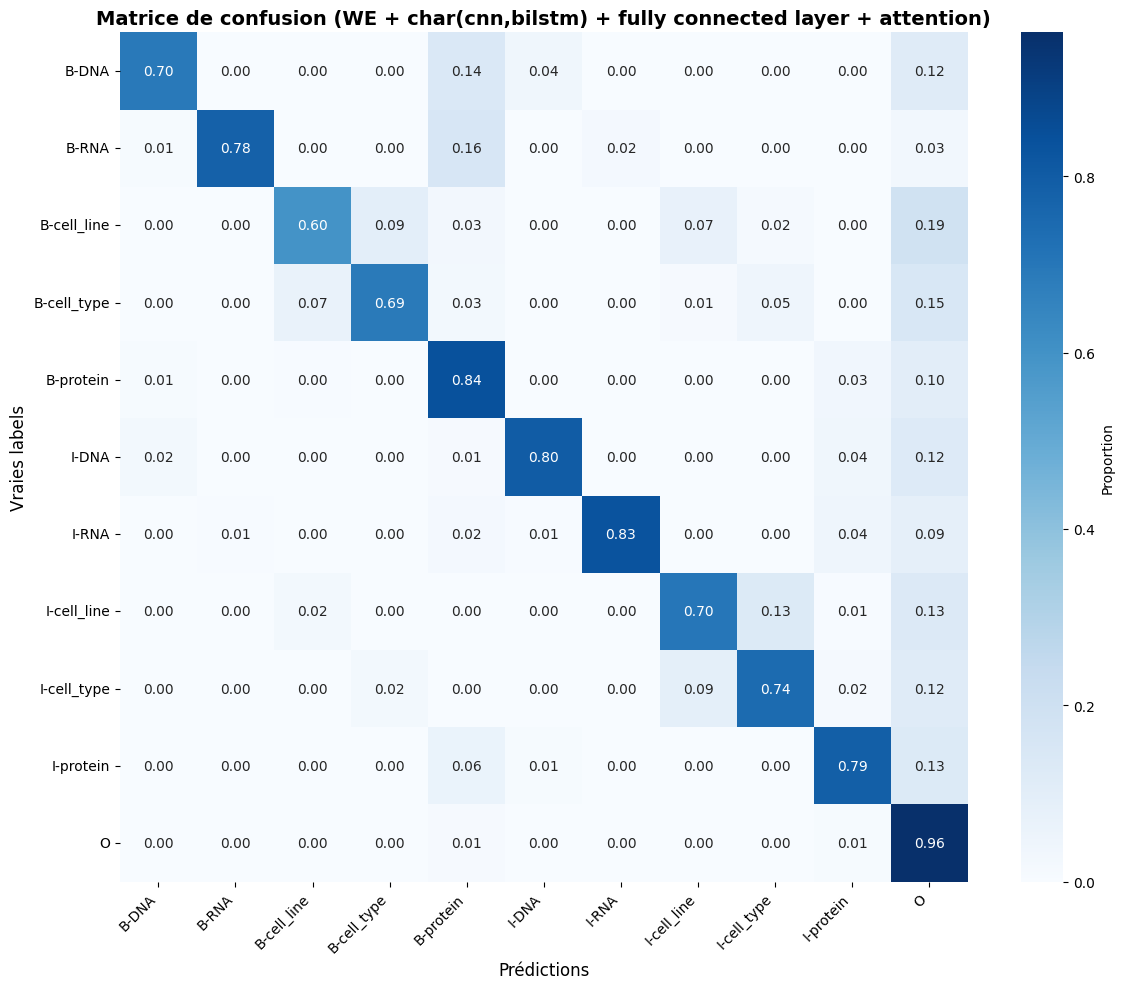

              precision    recall  f1-score   support

       B-DNA       0.72      0.70      0.71       857
       B-RNA       0.69      0.78      0.73        96
 B-cell_line       0.50      0.60      0.54       393
 B-cell_type       0.80      0.69      0.74      1730
   B-protein       0.72      0.84      0.78      4507
       I-DNA       0.81      0.80      0.81      1397
       I-RNA       0.76      0.83      0.80       156
 I-cell_line       0.55      0.70      0.62       792
 I-cell_type       0.85      0.74      0.79      2691
   I-protein       0.77      0.79      0.78      4222
           O       0.97      0.96      0.97     70962

    accuracy                           0.93     87803
   macro avg       0.74      0.77      0.75     87803
weighted avg       0.93      0.93      0.93     87803



In [15]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc, predictions_we_char__bilstm_cnn_attention_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

if set(predictions_we_char__bilstm_cnn_attention_fc) == set(targets_we_char__bilstm_cnn_attention_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention_fc,
        targets=targets_we_char__bilstm_cnn_attention_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + fully connected layer + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc[:10])}")

#### Comparaison

| #  | Combinaison                               | Accuracy globale (avec O) | Macro Precision | Macro Recall | **Macro F1** | **Weighted F1** |
| -- | ----------------------------------------- | ------------------------- | --------------- | ------------ | ------------ | --------------- |
| 1  | WE                                        | 0.9082                    | 0.74            | 0.54         | **0.62**     | 0.74            |
| 2  | WE + Attention                            | **0.9215**                | 0.75            | 0.67         | **0.70**     | 0.81            |
| 3  | WE + Char-BiLSTM                          | 0.9247                    | 0.76            | 0.69         | **0.72**     | 0.82            |
| 4  | WE + Char-BiLSTM + Attention              | **0.9291**                | 0.76            | 0.69         | **0.72**     | 0.82            |
| 5  | WE + Char-CNN                             | 0.9284                    | 0.76            | 0.68         | **0.71**     | 0.82            |
| 6  | WE + Char-CNN + Attention                 | 0.9268                    | 0.76            | 0.68         | **0.72**     | **0.83**        |
| 7  | WE + Char-(BiLSTM + CNN)                  | 0.9265                    | 0.76            | 0.68         | **0.71**     | 0.81            |
| 8  | WE + Char-(BiLSTM + CNN) + Attention      | **0.9291**                | **0.77**        | 0.68         | **0.72**     | **0.83**        |
| 9  | WE + Char-(BiLSTM + CNN) + FC             | 0.9141                    | 0.75            | **0.69**     | **0.71**     | 0.81            |
| 10 | WE + Char-(BiLSTM + CNN) + FC + Attention | 0.9271                    | 0.76            | 0.69         | **0.72**     | 0.82            |


| Composant ajouté                  | Comparaison directe | Effet observé (tes résultats)                          | Impact mesuré        | Interprétation technique                                                                              |
| --------------------------------- | ------------------- | ------------------------------------------------------ | -------------------- | ----------------------------------------------------------------------------------------------------- |
| **Word Embeddings (WE)**          | —                   | Macro-F1 = **0.62**                                    | Baseline             | Capture uniquement la sémantique lexicale, très sensible aux OOV et aux variantes morphologiques      |
| **Attention (sur WE)**            | (1) → (2)           | Macro-F1 **+0.08** (0.62 → 0.70) <br> Recall **+0.13** | Fort gain            | L’attention compense l’absence de contexte profond en repondérant dynamiquement les tokens pertinents |
| **Char-BiLSTM**                   | (1) → (3)           | Macro-F1 **+0.10**                                     | Très fort            | Capture la morphologie séquentielle (suffixes biomédicaux : *-ase*, *-in*, *-oma*)                    |
| **Char-BiLSTM + Attention**       | (3) → (4)           | F1 ≈ stable                                            | Léger                | L’attention devient redondante car le BiLSTM encode déjà le contexte local                            |
| **Char-CNN**                      | (1) → (5)           | Macro-F1 **+0.09**                                     | Fort                 | Capture des motifs morphologiques locaux (n-grammes de caractères)                                    |
| **Char-CNN + Attention**          | (5) → (6)           | Weighted-F1 **↑ 0.82 → 0.83**                          | Modéré               | L’attention améliore surtout les entités fréquentes (protein, cell_type)                              |
| **Char-BiLSTM + Char-CNN**        | (5)/(3) → (7)       | Gain marginal                                          | Faible               | Redondance partielle entre CNN (local) et BiLSTM (séquentiel)                                         |
| **Char-(BiLSTM+CNN) + Attention** | (7) → (8)           | **Meilleur Weighted-F1 = 0.83**                        | Fort                 | L’attention exploite la complémentarité CNN + BiLSTM                                                  |
| **Fully Connected (FC)**          | (7) → (9)           | Performance ↓                                          | Négatif seul         | Projection linéaire sans pondération contextuelle → perte d’information                               |
| **FC + Attention**                | (9) → (10)          | Performance récupérée                                  | Positif conditionnel | Le FC devient utile uniquement lorsqu’il est guidé par l’attention                                    |

Test on a set of examples

In [16]:
import torch

# =========================
# 1. Chargement checkpoint
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention_fc/best_model.pt" # com 10
#checkpoint_path="./checkpoints/JNLPBA/WE_char_bilstm_cnn_attention/best_model.pt"  # com 8
#checkpoint_path="./checkpoints/JNLPBA/WE_char_bilstm_cnn_fc/best_model.pt" # com 9
#checkpoint_path="./checkpoints/JNLPBA/WE_char_bilstm_cnn/best_model.pt" ## com 7
ckpt = torch.load(checkpoint_path, map_location=device)

# =========================
# 2. Récupération EXACTE des objets du training
# =========================
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_jnlpba["train_loader"]
vocab        = results_jnlpba["vocab"]
char_vocab   = results_jnlpba["char_vocab"]
tag_to_idx   = results_jnlpba["tag_to_idx"]
idx_to_tag   = results_jnlpba["idx_to_tag"]

# =========================
# 3. Reconstruction du modèle (IDENTIQUE au training)
# =========================
model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_jnlpba["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=256,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# =========================
# 4. Fonction de prédiction CORRECTE
# =========================
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



# =========================
# 5. Tes phrases de test
# =========================
test_data = [
    # Protein + Cell line
    (
        ["Octamer-binding", "proteins", "from", "HeLa", "cells", "stimulate", "transcription"],
        ["B-protein", "I-protein", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA example
    (
        ["The", "BRCA1", "gene", "is", "associated", "with", "breast", "cancer"],
        ["O", "B-DNA", "O", "O", "O", "O", "B-cell_type", "O"]
    ),
    # RNA example
    (
        ["mRNA", "expression", "in", "Jurkat", "cells", "was", "upregulated"],
        ["B-RNA", "O", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # Cell type example
    (
        ["T", "lymphocytes", "play", "a", "key", "role", "in", "immune", "response"],
        ["B-cell_type", "I-cell_type", "O", "O", "O", "O", "O", "O", "O"]
    ),
    # Overlapping adjacent entities
    (
        ["p53", "and", "BRCA1", "regulate", "DNA", "replication"],
        ["B-protein", "O", "B-DNA", "O", "B-DNA", "O"]
    ),
    # Mixed entities
    (
        ["The", "RNA", "of", "Jurkat", "T", "cells", "is", "similar", "to", "HeLa", "cells"],
        ["O", "B-RNA", "O", "B-cell_line", "B-cell_type", "I-cell_line", "O", "O", "O", "B-cell_line", "I-cell_line"]
    ),
    # Long sentence with multiple types
    (
        ["p53", "protein", "binds", "to", "BRCA1", "DNA", "in", "HeLa", "and", "Jurkat", "cells", "during", "transcription"],
        ["B-protein", "I-protein", "O", "O", "B-DNA", "I-DNA", "O", "B-cell_line", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA + RNA + protein in one sentence
    (
        ["BRCA1", "gene", "transcribes", "mRNA", "which", "produces", "p53", "protein"],
        ["B-DNA", "O", "O", "B-RNA", "O", "O", "B-protein", "I-protein"]
    ),
]

# =========================
# 6. Évaluation lisible
# =========================
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")

Example 1
Token           Gold            Predicted      
--------------------------------------------------
Octamer-binding B-protein       B-protein      
proteins        I-protein       I-protein      
from            O               O              
HeLa            B-cell_line     B-cell_line    
cells           I-cell_line     I-cell_line    
stimulate       O               O              
transcription   O               O              

Token accuracy (sentence): 1.0000

Example 2
Token           Gold            Predicted      
--------------------------------------------------
The             O               O              
BRCA1           B-DNA           B-DNA          
gene            O               I-DNA          
is              O               O              
associated      O               O              
with            O               O              
breast          B-cell_type     O              
cancer          O               O              

Token accuracy (sentence)